In [9]:
# Import Required Libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import tensor
import numpy as np
import torchvision
from torchvision import datasets,transforms,models
from torchvision.transforms.functional import InterpolationMode
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.optim import Adam, lr_scheduler
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import shutil
import glob
!pip install torchmetrics
import torchmetrics
!pip install patool
import patoolib
import pathlib
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score
from sklearn.model_selection import StratifiedKFold
import subprocess

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

### VoltaVision model architecture

class VoltaVision(nn.Module):
    def __init__(self, num_classes=3):
        super(VoltaVision, self).__init__()

        # Input shape = (64, 3, 30, 30)
        # Output size after convolutional layer = (w-f+2p)/s + 1 = (30-3+2)/1 + 1 = 30
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        #Input shape = (64, 12, 30, 30)
        self.bn1 = nn.BatchNorm2d(num_features=12)
        self.relu1 = nn.ReLU()

        # Input shape = (64, 12, 30, 30)
        # Output size after max pooling = 30/2 = 15
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        # Input shape = (64, 12, 15, 15)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.relu3 = nn.ReLU()
        #shape = (64, 32, 15, 15)

        self.fc = nn.Linear(in_features=15*15*32, out_features=num_classes)

    def forward(self, input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)

        output = self.maxpool1(output)

        output = self.conv2(output)
        output = self.relu2(output)

        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)

        #reshaping the output to feed into the fully connected layer
        output = output.view(-1, 15*15*32)

        output = self.fc(output)

        return output


def train_model(model, criterion, optimizer, scheduler,  dataloaders, dataset_sizes, num_epochs=15):
    since = time.time()
    torch.cuda.reset_peak_memory_stats(device)    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # create a list to store the training and validation accuracy values
    train_acc_list = []
    val_acc_list = []

    # create a list to store the training and validation loss values
    train_loss_list = []
    val_loss_list = []

    # initialize metric
    metric = torchmetrics.classification.Accuracy(task="multiclass", num_classes=3)
    predicted_labels = []
    ground_truth_labels = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-'*10)

        #Training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            #Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                #forward
                #track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #_,preds = torch.max(outputs,1)
                    #loss = criterion(outputs,labels)
                    #googlenetcprfix
                    if str(type(outputs)) == "<class 'torch.Tensor'>":
                        _,preds = torch.max(outputs,1)
                        loss = criterion(outputs,labels)
                    else :
                        _,preds = torch.max(outputs.logits,1)
                        loss = criterion(outputs.logits,labels)

                    #backward + optimize only in train
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_acc_list.append(epoch_acc.item())
                train_loss_list.append(epoch_loss)
            elif phase == 'val':
                val_acc_list.append(epoch_acc.item())
                val_loss_list.append(epoch_loss)

            predicted_labels.append(preds.cpu())
            ground_truth_labels.append(labels.cpu())


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            #deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    #calculate accuracy
    predicted_labels = torch.cat(predicted_labels)
    ground_truth_labels = torch.cat(ground_truth_labels)
    accuracy = Accuracy(task="multiclass", num_classes=3)
    accuracy(predicted_labels, ground_truth_labels)
    print(f'Accuracy: {accuracy.compute():.4f}')

    #calculate precision
    precision = Precision(task="multiclass", average='macro', num_classes=3)
    precision(predicted_labels, ground_truth_labels)
    print(f'Precision: {precision.compute():.4f}')

    #calculate recall
    recall = Recall(task="multiclass", average='macro', num_classes=3)
    recall(predicted_labels, ground_truth_labels)
    print(f'Recall: {recall.compute():.4f}')

    #calculate f1 score
    f1 = F1Score(task="multiclass", average='macro', num_classes=3)
    f1(predicted_labels, ground_truth_labels)
    print(f'F1: {f1.compute():.4f}')

    #calculate confusion matrix
    cm = torchmetrics.functional.confusion_matrix(predicted_labels, ground_truth_labels, num_classes=3, task="multiclass")
    print(f'Confusion Matrix: \n{cm}')

    #plot the training and validation accuracy
    plt.figure(figsize=(10, 6))

    plt.plot(train_acc_list, label='Training Accuracy')
    plt.plot(val_acc_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

    #plot the training and validation loss

    plt.figure(figsize=(10, 6))

    plt.plot(train_loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

    metrics = {}
    metrics['accuracy'] = accuracy.compute()
    metrics['precision'] = precision.compute()
    metrics['recall'] = recall.compute()
    metrics['f1'] = f1.compute()
    metrics['time'] = time_elapsed
    metrics['memory'] = torch.cuda.max_memory_allocated()/(1024*1024)

    #load best model weights
    model.load_state_dict(best_model_wts)
    return model, metrics


def print_metrics(metrics):
    print(f'Average accuracy: {metrics["accuracy"]:.4f}')
    print(f'Average precision: {metrics["precision"]:.4f}')
    print(f'Average recall: {metrics["recall"]:.4f}')
    print(f'Average F1 score: {metrics["f1"]:.4f}')
    print(f'Average Time elapsed: {metrics["time"]:.4f} seconds')
    print(f'Memory Usage: {metrics["memory"]:.4f} MiB')


def get_transforms(model_name):

  # resize_transform = transforms.Resize(224, interpolation=InterpolationMode.BILINEAR)
  # resize_transform = transforms.Resize(224, interpolation=InterpolationMode.BICUBIC)
  # resize_transform = transforms.Resize(224, interpolation=InterpolationMode.NEAREST)

  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229,0.224,0.225])
  if model_name in ['googlenet', 'resnet18', 'alexnet']:
      data_transforms = {
          'train':transforms.Compose([
              transforms.RandomResizedCrop(224, interpolation=InterpolationMode.NEAREST),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              transforms.Normalize(mean,std)
          ]),
          'val':transforms.Compose([
              transforms.Resize(256, interpolation=InterpolationMode.NEAREST),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              transforms.Normalize(mean,std)
          ])
      }
  elif model_name == 'inceptionv3':
      data_transforms = {
          'train':transforms.Compose([
              transforms.Resize((299, 299)),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              transforms.Normalize(mean,std)
          ]),
          'val':transforms.Compose([
              transforms.Resize((299, 299)),
              transforms.ToTensor(),
              transforms.Normalize(mean,std)
          ])
      }
  elif model_name == 'vgg16':
      data_transforms = {
          'train':transforms.Compose([
              transforms.Resize(224),
              transforms.CenterCrop(224),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              transforms.Normalize(mean,std)
          ]),
          'val':transforms.Compose([
              transforms.Resize(224),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              transforms.Normalize(mean,std)
          ])
      }
  else:
    data_transforms = {
        'train':transforms.Compose([
            transforms.Resize((30, 30)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)  # Normalize all three channels
        ]),
        'val':transforms.Compose([
            transforms.Resize((30, 30)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)  # Normalize all three channels
        ])
    }
  return data_transforms

#returns pretrained model trained on ImageNet dataset
def get_pretrained_model(model_name, num_classes, pretrained, device='cpu', weights=None):
  if pretrained == True:
      if model_name == 'googlenet':
          return models.googlenet(pretrained=True)
      elif model_name == 'inceptionv3':
          return models.inception_v3(pretrained=True)
      elif model_name == 'vgg16':
          return models.vgg16(pretrained=True)
      elif model_name == 'resnet18':
          return models.resnet18(pretrained=True)
      elif model_name == 'alexnet':
          return models.alexnet(pretrained=True)
      else:
          #load voltavision here.
          raise ValueError(f"Invalid model_name: {model_name}")
  else:
    if model_name == 'googlenet':
        return models.googlenet(weights=weights).to(device)
    elif model_name == 'inceptionv3':
        return models.inception_v3(weights=weights).to(device)
    elif model_name == 'vgg16':
        return models.vgg16(weights=weights).to(device)
    elif model_name == 'resnet18':
        return models.resnet18(weights=weights).to(device)
    elif model_name == 'alexnet':
        return models.alexnet(weights=weights).to(device)
    elif model_name == 'voltavision':
        return VoltaVision(num_classes).to(device)
    else:
        raise ValueError(f"Invalid model_name: {model_name}")




def preTrainImageNet(model_name, classes):
  data_transforms = get_transforms(model_name)
  # Get a list of all image filenames and corresponding labels
  all_filenames = []
  all_labels = []
  # Iterate through each class folder and associate each image with corresponding lable
  for class_name in classes:
      class_folder = os.path.join(folder_path, class_name)
      class_filenames = [os.path.join(class_folder, filename) for filename in os.listdir(class_folder)]

      # Extend the list of all_filenames and all_labels
      all_filenames.extend(class_filenames)
      all_labels.extend([class_name] * len(class_filenames))

  # Use StratifiedKFold for creating folds
  num_folds = 5
  stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

  all_metrics = []

  # Perform stratified k-fold cross-validation
  for i, (train_idx, test_idx) in enumerate(stratified_kfold.split(all_filenames, all_labels)):
    train_FileNames = [all_filenames[idx] for idx in train_idx]
    val_FileNames = [all_filenames[idx] for idx in test_idx]
    print('Fold: ',i)
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))
    fold_dir = f'./splitted_dataset/fold{i}'
    if not os.path.exists(fold_dir):
        os.makedirs(fold_dir+'/train')
        os.makedirs(fold_dir+'/val')

        # Creating the class folders in train and validation folders
        for class_name in classes:
            os.makedirs(fold_dir+'/train/' + class_name)
            os.makedirs(fold_dir+'/val/' + class_name)

    for name in train_FileNames:
        class_name = name.split('/')[1]
        shutil.copy(name, fold_dir+'/train/' + class_name)
    for name in val_FileNames:
        class_name = name.split('/')[1]
        shutil.copy(name, fold_dir+'/val/' + class_name)


    sets = ['train','val']
    image_datasets = {x:datasets.ImageFolder(os.path.join(fold_dir,x),
                                            data_transforms[x])
                    for x in ['train','val']}
    dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,
                                                shuffle=True,num_workers=0)
                    for x in ['train','val']}

    dataset_sizes = {x:len(image_datasets[x]) for x in ['train','val']}


    pretrained_model_ImageNet = get_pretrained_model(model_name, 1000, True)

    #freezing previous layers
    for param in pretrained_model_ImageNet.parameters():
        param.requires_grad = False

    #exchange the last layer
    num_classes = 3

    if model_name in ['googlenet', 'resnet18']:
        pretrained_model_ImageNet.fc = nn.Linear(in_features=pretrained_model_ImageNet.fc.in_features, out_features=num_classes, device=device)
    elif model_name in ['alexnet', 'vgg16']:
        num_ftrs = pretrained_model_ImageNet.classifier[6].in_features
        pretrained_model_ImageNet.classifier[6] = nn.Linear(num_ftrs, 3)
    elif model_name == 'inceptionv3':
        num_ftrs = pretrained_model_ImageNet.fc.in_features
        pretrained_model_ImageNet.fc = nn.Linear(num_ftrs, 3)
    else:
        #use voltavision here.
        raise ValueError(f"Invalid model_name: {model_name}")

    pretrained_model_ImageNet.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(pretrained_model_ImageNet.parameters(),lr=0.001)

    #scheduler
    step_lr_scheduler = lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

    model_ft, metrics = train_model(pretrained_model_ImageNet, criterion, optimizer, step_lr_scheduler, dataloaders, dataset_sizes, num_epochs=25)

    all_metrics.append(metrics)

  avg_metrics = {key: np.mean([m[key] for m in all_metrics]) for key in all_metrics[0]}
  print_metrics(avg_metrics)

# Building Pre-Trained Model using CPR

def build_preTrain(model_name, dataset_name, num_classes):
  if not os.path.exists(dataset_name):
    patoolib.extract_archive(dataset_name+'.zip')
  # Extracting the dataset and creating the train and test folders
  data_dir = pathlib.Path(dataset_name)
  classes = os.listdir(data_dir)
  print('classes: ',classes)

  # Creating the train and test folders
  if not os.path.exists('./' + dataset_name + '_pretrain_dataset'):
      os.makedirs('./' + dataset_name + '_pretrain_dataset/train')
      os.makedirs('./' + dataset_name + '_pretrain_dataset/test')

      # Creating the class folders in train and test folders
      for i in classes:
          os.makedirs('./' + dataset_name + '_pretrain_dataset/train/' + i)
          os.makedirs('./' + dataset_name + '_pretrain_dataset/test/' + i)

  random.seed(0)
  train_count = 0
  test_count = 0
  # Splitting the dataset into train and test sets
  for i in classes:
      src = dataset_name + '/' + i # Folder to copy images from
      allFileNames = os.listdir(src)
      np.random.shuffle(allFileNames)
      train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                                [int(len(allFileNames)*0.8)])
      train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
      test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]
      print('Total images: ', len(allFileNames))
      print('Training: ', len(train_FileNames))
      print('Testing: ', len(test_FileNames))

      train_count += len(train_FileNames)
      test_count += len(test_FileNames)
      # Copy-pasting images
      for name in train_FileNames:
          shutil.copy(name, './' + dataset_name + '_pretrain_dataset/train/' + i)
      for name in test_FileNames:
          shutil.copy(name, './' + dataset_name + '_pretrain_dataset/test/' + i)

  data_transforms = get_transforms(model_name)

  train_dir = './' + dataset_name + '_pretrain_dataset/train'
  train_dataloader = DataLoader(
      torchvision.datasets.ImageFolder(train_dir, transform=data_transforms['train']),
      batch_size=64, shuffle=True
  )

  test_dir = './' + dataset_name + '_pretrain_dataset/test'
  test_dataloader = DataLoader(
      torchvision.datasets.ImageFolder(test_dir, transform=data_transforms['train']),
      batch_size=64, shuffle=True
  )

  print('train_count: ', train_count)
  print('test_count: ', test_count)

  pretrained_model_CPR = get_pretrained_model(model_name, num_classes, False, device)


  if model_name in ['googlenet', 'resnet18', 'inceptionv3', 'voltavision']:
    pretrained_model_CPR.fc = nn.Linear(in_features=pretrained_model_CPR.fc.in_features, out_features=num_classes, device=device)
  elif model_name in ['alexnet', 'vgg16']:
    num_ftrs = pretrained_model_CPR.classifier[6].in_features
    pretrained_model_CPR.classifier[6] = nn.Linear(num_ftrs, num_classes, device=device)
  else:
    raise ValueError(f"Invalid model_name: {model_name}")


  # Loss and optimizer
  optimizer = Adam(pretrained_model_CPR.parameters(), lr=0.001, weight_decay=0.0001)
  loss_fn = nn.CrossEntropyLoss()
  scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

  #training the model and saving best model
  num_epochs = 10
  best_accuracy = 0.0

  for epoch in range(num_epochs):
      #Evaluation and training on training dataset
      pretrained_model_CPR.train()
      train_accuracy = 0.0
      train_loss = 0.0

      for i, (images, labels) in enumerate(train_dataloader):
          if torch.cuda.is_available():
              images = Variable(images.cuda())
              labels = Variable(labels.cuda())

          optimizer.zero_grad()

          outputs = pretrained_model_CPR(images)
          if str(type(outputs)) != "<class 'torch.Tensor'>":
            outputs_logits = outputs.logits
          else:
            outputs_logits = outputs
          loss = loss_fn(outputs_logits, labels)
          loss.backward()
          optimizer.step()

          train_loss += loss.cpu().data*images.size(0)
          _, prediction = torch.max(outputs_logits, 1)

          train_accuracy += int(torch.sum(prediction==labels.data))

      train_accuracy = train_accuracy/train_count
      train_loss = train_loss/train_count

      #Evaluation on testing dataset
      pretrained_model_CPR.eval()
      test_accuracy = 0.0
      for i, (images, labels) in enumerate(test_dataloader):
          if torch.cuda.is_available():
              images = Variable(images.cuda())
              labels = Variable(labels.cuda())

          outputs = pretrained_model_CPR(images)
          _, prediction = torch.max(outputs.data, 1)
          test_accuracy += int(torch.sum(prediction==labels.data))

      test_accuracy = test_accuracy/test_count

      print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))

      #Save the best model
      if test_accuracy > best_accuracy:
          torch.save(pretrained_model_CPR.state_dict(), 'best_'+ dataset_name +'_checkpoint.model')
          best_accuracy = test_accuracy

      scheduler.step()

def preTrainCPR(model_name, pretrain_dataset, pretrain_num_classes, classes):
  build_preTrain(model_name, pretrain_dataset, pretrain_num_classes)
  data_transforms = get_transforms(model_name)
  # Get a list of all image filenames and corresponding labels
  all_filenames = []
  all_labels = []
  # Iterate through each class folder and associate each image with corresponding lable
  for class_name in classes:
      class_folder = os.path.join(folder_path, class_name)
      class_filenames = [os.path.join(class_folder, filename) for filename in os.listdir(class_folder)]

      # Extend the list of all_filenames and all_labels
      all_filenames.extend(class_filenames)
      all_labels.extend([class_name] * len(class_filenames))

  # Use StratifiedKFold for creating folds
  num_folds = 5
  stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

  all_metrics = []

  # Perform stratified k-fold cross-validation
  for i, (train_idx, test_idx) in enumerate(stratified_kfold.split(all_filenames, all_labels)):
      train_FileNames = [all_filenames[idx] for idx in train_idx]
      val_FileNames = [all_filenames[idx] for idx in test_idx]
      print('Fold: ',i)
      print('Training: ', len(train_FileNames))
      print('Validation: ', len(val_FileNames))
      fold_dir = f'./splitted_dataset/fold{i}'
      if not os.path.exists(fold_dir):
          os.makedirs(fold_dir+'/train')
          os.makedirs(fold_dir+'/val')

          # Creating the class folders in train and validation folders
          for class_name in classes:
              os.makedirs(fold_dir+'/train/' + class_name)
              os.makedirs(fold_dir+'/val/' + class_name)

      for name in train_FileNames:
          class_name = name.split('/')[1]
          shutil.copy(name, fold_dir+'/train/' + class_name)
      for name in val_FileNames:
          class_name = name.split('/')[1]
          shutil.copy(name, fold_dir+'/val/' + class_name)


      sets = ['train','val']
      image_datasets = {x:datasets.ImageFolder(os.path.join(fold_dir,x),
                                              data_transforms[x])
                      for x in ['train','val']}
      dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,
                                                  shuffle=True,num_workers=0)
                      for x in ['train','val']}

      dataset_sizes = {x:len(image_datasets[x]) for x in ['train','val']}


      #pretrained_model = get_pretrained_model(model_name, True)
      # loading the skeleton
      pretrained_model_CPR = get_pretrained_model(model_name, pretrain_num_classes, False, device)


      #pretrained_model_CPR.fc = nn.Linear(in_features=pretrained_model_CPR.fc.in_features, out_features=num_classes, device=device)
      if model_name in ['googlenet', 'resnet18', 'voltavision', 'inceptionv3']:
        pretrained_model_CPR.fc = nn.Linear(in_features=pretrained_model_CPR.fc.in_features, out_features=pretrain_num_classes, device=device)
      elif model_name in ['alexnet', 'vgg16']:
        num_ftrs = pretrained_model_CPR.classifier[6].in_features
        pretrained_model_CPR.classifier[6] = nn.Linear(num_ftrs, pretrain_num_classes)
      else:
        raise ValueError(f"Invalid model_name: {model_name}")



      #load the best_checkpoint.model
      checkpoint = torch.load('best_'+ pretrain_dataset +'_checkpoint.model')
      pretrained_model_CPR.load_state_dict(checkpoint)

      #freezing previous layers
      for param in pretrained_model_CPR.parameters():
        param.requires_grad = False

      num_classes = 3
      #pretrained_model_CPR.fc = nn.Linear(in_features=pretrained_model_CPR.fc.in_features, out_features=num_classes, device=device)
      if model_name in ['googlenet', 'resnet18', 'voltavision', 'inceptionv3']:
        pretrained_model_CPR.fc = nn.Linear(in_features=pretrained_model_CPR.fc.in_features, out_features=num_classes, device=device)
      elif model_name in ['alexnet', 'vgg16']:
        num_ftrs = pretrained_model_CPR.classifier[6].in_features
        pretrained_model_CPR.classifier[6] = nn.Linear(num_ftrs, num_classes)
      else:
        raise ValueError(f"Invalid model_name: {model_name}")



      #exchange the last layer
      # num_ftrs = pretrained_model_CPR.fc.in_features
      # pretrained_model_CPR.fc = nn.Linear(num_ftrs, 3)

      pretrained_model_CPR.to(device)

      criterion = nn.CrossEntropyLoss()
      optimizer = optim.SGD(pretrained_model_CPR.parameters(),lr=0.001)

      #scheduler
      step_lr_scheduler = lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

      model_ft, metrics = train_model(pretrained_model_CPR,criterion,optimizer,step_lr_scheduler, dataloaders, dataset_sizes,num_epochs=25)
      all_metrics.append(metrics)

  avg_metrics = {key: np.mean([m[key] for m in all_metrics]) for key in all_metrics[0]}
  print_metrics(avg_metrics)

# Fine-Tuning using the THB dataset

if not os.path.exists('./THB_dataset'):
    patoolib.extract_archive('THB_dataset.zip')


folder_path = 'THB_dataset'
classes = os.listdir(folder_path)
print(classes)


## CPR

## EleComp Dataset

## ECD dataset

# preTrainCPR('voltavision', 'CPR_dataset', 3, classes)



cuda:0
['Bluetooth', 'Humidity', 'Transistor']


classes:  ['solenoid', 'electric-relay', 'heat-sink', 'Electrolytic-capacitor', 'potentiometer']
Total images:  317
Training:  253
Testing:  64
Total images:  420
Training:  336
Testing:  84
Total images:  420
Training:  336
Testing:  84
Total images:  403
Training:  322
Testing:  81
Total images:  468
Training:  374
Testing:  94
train_count:  1621
test_count:  407
Epoch: 0 Train Loss: tensor(2.1019) Train Accuracy: 0.4404688463911166 Test Accuracy: 1.7985257985257985
Epoch: 1 Train Loss: tensor(1.5472) Train Accuracy: 0.6520666255397902 Test Accuracy: 2.312039312039312
Epoch: 2 Train Loss: tensor(1.2907) Train Accuracy: 0.7624922887106724 Test Accuracy: 2.5036855036855035
Epoch: 3 Train Loss: tensor(1.0835) Train Accuracy: 0.8587291795188156 Test Accuracy: 2.9705159705159705
Epoch: 4 Train Loss: tensor(0.8777) Train Accuracy: 0.9660703269586675 Test Accuracy: 3.2457002457002457
Epoch: 5 Train Loss: tensor(0.6507) Train Accuracy: 1.1011721159777914 Test Accuracy: 3.3169533169533167
Epo

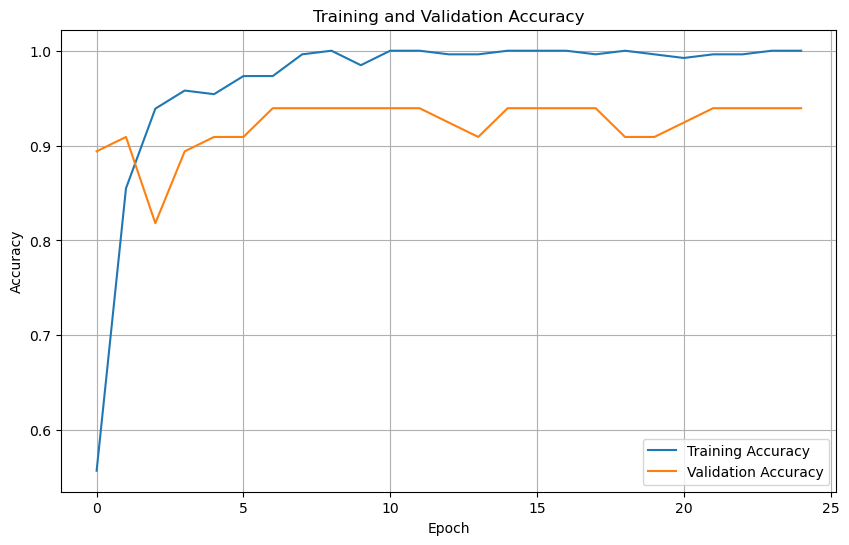

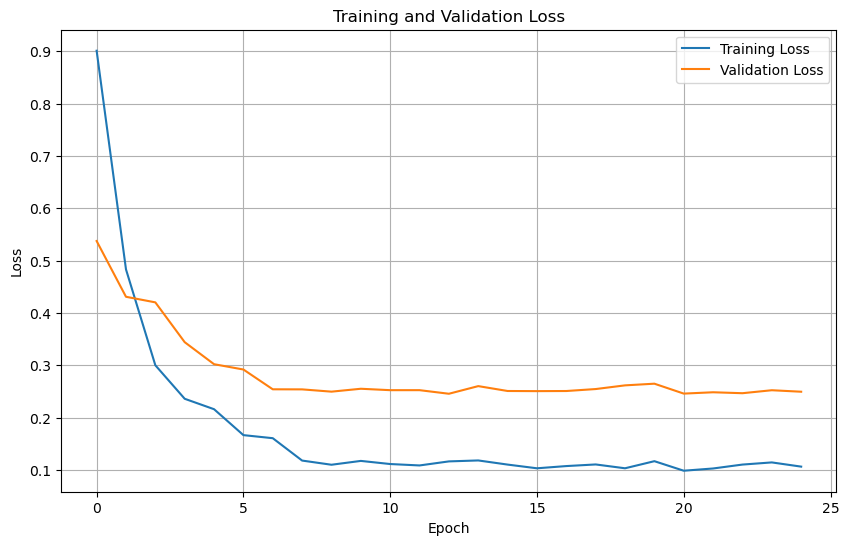

Fold:  1
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 0.8216 Acc: 0.6641
val Loss: 0.7314 Acc: 0.6667

Epoch 1/24
----------
train Loss: 0.4380 Acc: 0.8740
val Loss: 0.6031 Acc: 0.6818

Epoch 2/24
----------
train Loss: 0.3185 Acc: 0.9198
val Loss: 0.3780 Acc: 0.9242

Epoch 3/24
----------
train Loss: 0.2399 Acc: 0.9351
val Loss: 0.3270 Acc: 0.9091

Epoch 4/24
----------
train Loss: 0.1779 Acc: 0.9695
val Loss: 0.3118 Acc: 0.8788

Epoch 5/24
----------
train Loss: 0.1587 Acc: 0.9809
val Loss: 0.2818 Acc: 0.9545

Epoch 6/24
----------
train Loss: 0.1374 Acc: 0.9847
val Loss: 0.2565 Acc: 0.9394

Epoch 7/24
----------
train Loss: 0.1259 Acc: 0.9962
val Loss: 0.2525 Acc: 0.9697

Epoch 8/24
----------
train Loss: 0.1182 Acc: 0.9962
val Loss: 0.2603 Acc: 0.9545

Epoch 9/24
----------
train Loss: 0.1222 Acc: 0.9924
val Loss: 0.2610 Acc: 0.9394

Epoch 10/24
----------
train Loss: 0.1119 Acc: 1.0000
val Loss: 0.2534 Acc: 0.9697

Epoch 11/24
----------
train Loss: 0.1109 Acc:

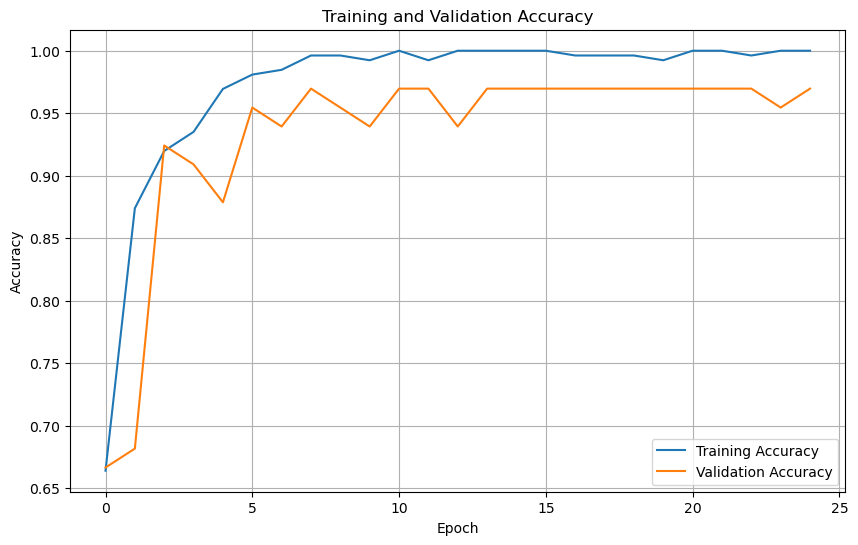

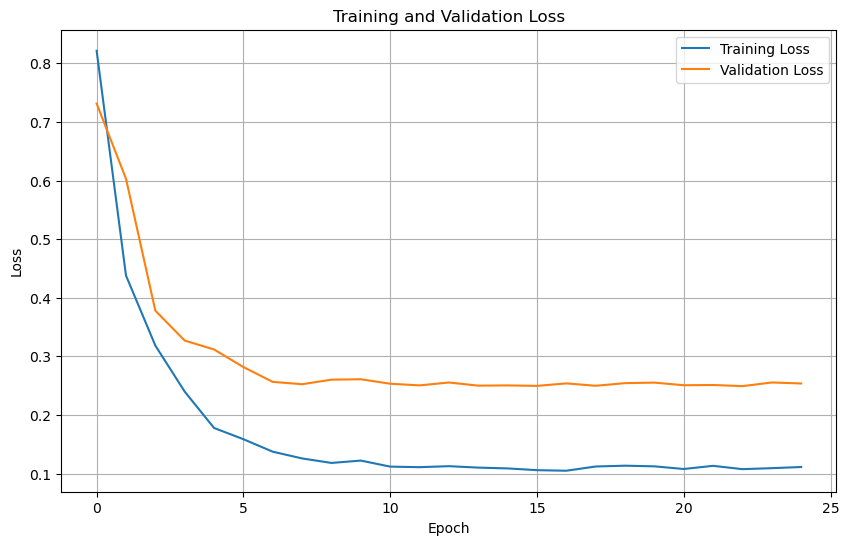

Fold:  2
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 0.8557 Acc: 0.6450
val Loss: 0.6105 Acc: 0.7273

Epoch 1/24
----------
train Loss: 0.4270 Acc: 0.8779
val Loss: 0.4386 Acc: 0.8333

Epoch 2/24
----------
train Loss: 0.2870 Acc: 0.9542
val Loss: 0.3848 Acc: 0.8636

Epoch 3/24
----------
train Loss: 0.2277 Acc: 0.9580
val Loss: 0.3629 Acc: 0.8636

Epoch 4/24
----------
train Loss: 0.1876 Acc: 0.9771
val Loss: 0.3123 Acc: 0.8788

Epoch 5/24
----------
train Loss: 0.1483 Acc: 0.9885
val Loss: 0.3038 Acc: 0.8788

Epoch 6/24
----------
train Loss: 0.1303 Acc: 0.9962
val Loss: 0.2979 Acc: 0.8788

Epoch 7/24
----------
train Loss: 0.1046 Acc: 1.0000
val Loss: 0.2906 Acc: 0.8636

Epoch 8/24
----------
train Loss: 0.1205 Acc: 0.9962
val Loss: 0.2910 Acc: 0.8636

Epoch 9/24
----------
train Loss: 0.1107 Acc: 0.9962
val Loss: 0.2865 Acc: 0.8788

Epoch 10/24
----------
train Loss: 0.1091 Acc: 1.0000
val Loss: 0.2892 Acc: 0.8636

Epoch 11/24
----------
train Loss: 0.1081 Acc:

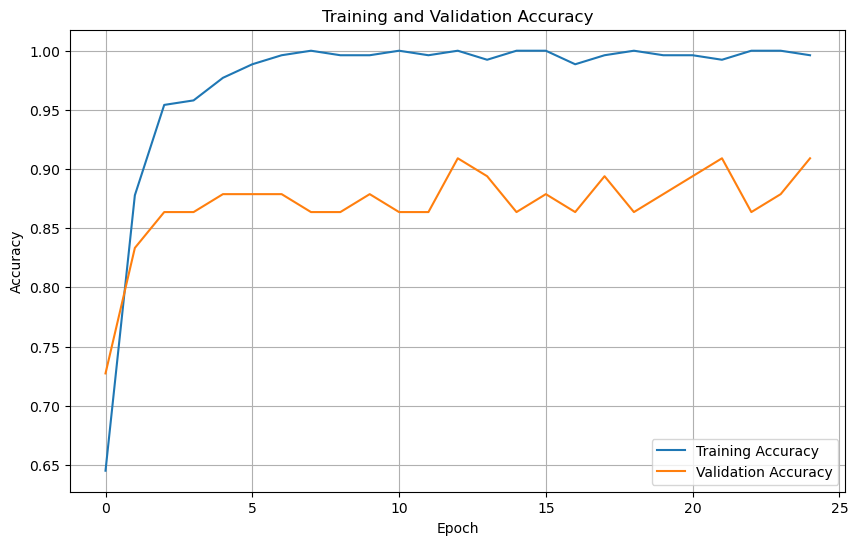

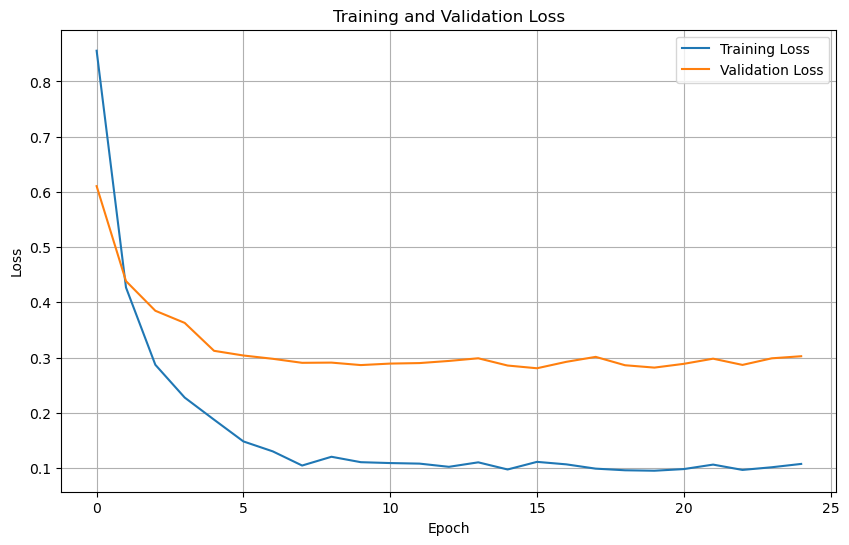

Fold:  3
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 0.8148 Acc: 0.6426
val Loss: 0.6033 Acc: 0.8154

Epoch 1/24
----------
train Loss: 0.4365 Acc: 0.8859
val Loss: 0.5734 Acc: 0.8000

Epoch 2/24
----------
train Loss: 0.2841 Acc: 0.9430
val Loss: 0.4759 Acc: 0.8462

Epoch 3/24
----------
train Loss: 0.2374 Acc: 0.9620
val Loss: 0.3946 Acc: 0.8769

Epoch 4/24
----------
train Loss: 0.1962 Acc: 0.9772
val Loss: 0.3768 Acc: 0.8923

Epoch 5/24
----------
train Loss: 0.1480 Acc: 0.9848
val Loss: 0.3573 Acc: 0.8923

Epoch 6/24
----------
train Loss: 0.1194 Acc: 1.0000
val Loss: 0.3377 Acc: 0.8923

Epoch 7/24
----------
train Loss: 0.1158 Acc: 0.9924
val Loss: 0.3513 Acc: 0.8923

Epoch 8/24
----------
train Loss: 0.1016 Acc: 1.0000
val Loss: 0.3410 Acc: 0.8923

Epoch 9/24
----------
train Loss: 0.1063 Acc: 0.9962
val Loss: 0.3455 Acc: 0.8923

Epoch 10/24
----------
train Loss: 0.1124 Acc: 0.9962
val Loss: 0.3371 Acc: 0.8923

Epoch 11/24
----------
train Loss: 0.1203 Acc:

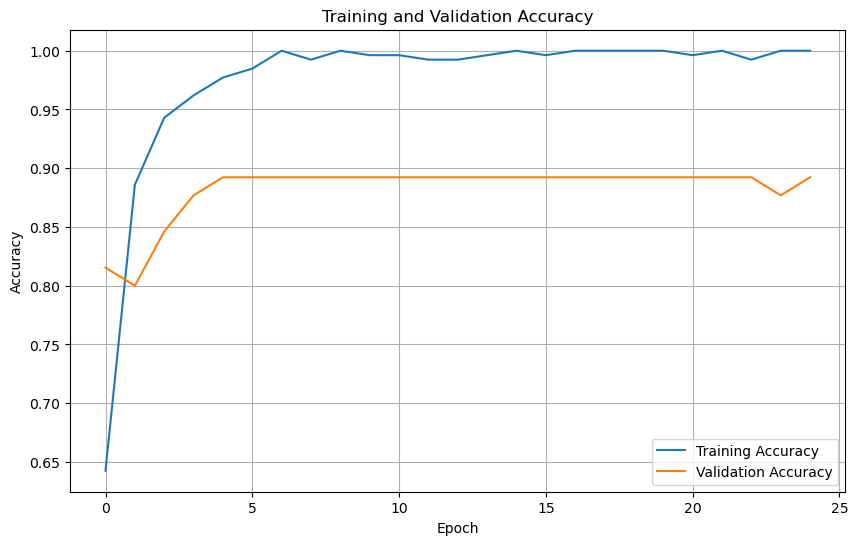

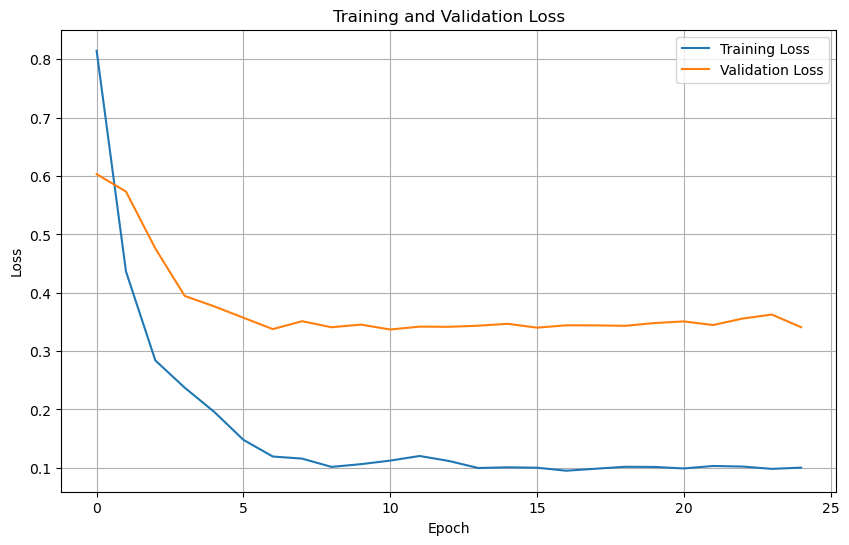

Fold:  4
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 0.8431 Acc: 0.6464
val Loss: 0.5747 Acc: 0.7692

Epoch 1/24
----------
train Loss: 0.4809 Acc: 0.8403
val Loss: 0.5346 Acc: 0.7692

Epoch 2/24
----------
train Loss: 0.3147 Acc: 0.9087
val Loss: 0.3572 Acc: 0.8923

Epoch 3/24
----------
train Loss: 0.2304 Acc: 0.9772
val Loss: 0.3054 Acc: 0.9231

Epoch 4/24
----------
train Loss: 0.2064 Acc: 0.9696
val Loss: 0.2819 Acc: 0.9231

Epoch 5/24
----------
train Loss: 0.1428 Acc: 0.9924
val Loss: 0.3212 Acc: 0.9077

Epoch 6/24
----------
train Loss: 0.1389 Acc: 0.9962
val Loss: 0.2612 Acc: 0.9231

Epoch 7/24
----------
train Loss: 0.1199 Acc: 0.9962
val Loss: 0.2554 Acc: 0.9077

Epoch 8/24
----------
train Loss: 0.1077 Acc: 0.9962
val Loss: 0.2694 Acc: 0.9077

Epoch 9/24
----------
train Loss: 0.1065 Acc: 1.0000
val Loss: 0.2529 Acc: 0.9077

Epoch 10/24
----------
train Loss: 0.1107 Acc: 1.0000
val Loss: 0.2548 Acc: 0.9231

Epoch 11/24
----------
train Loss: 0.1038 Acc:

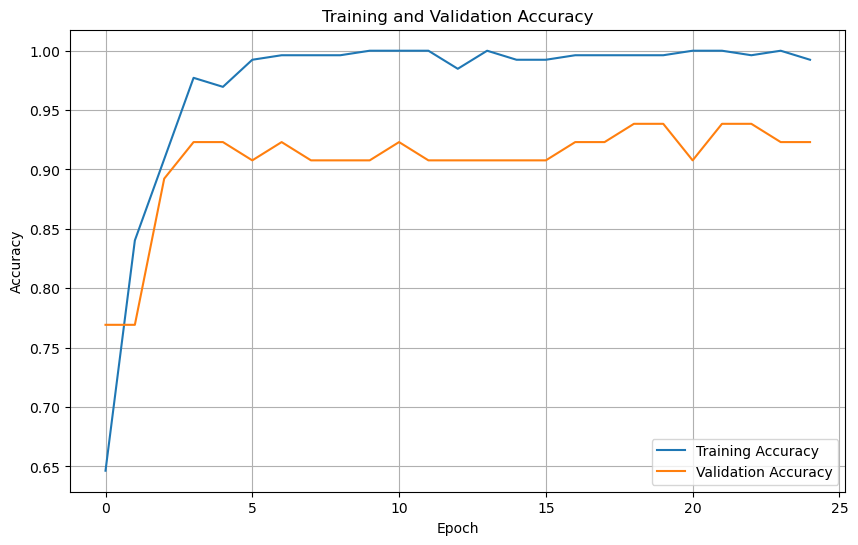

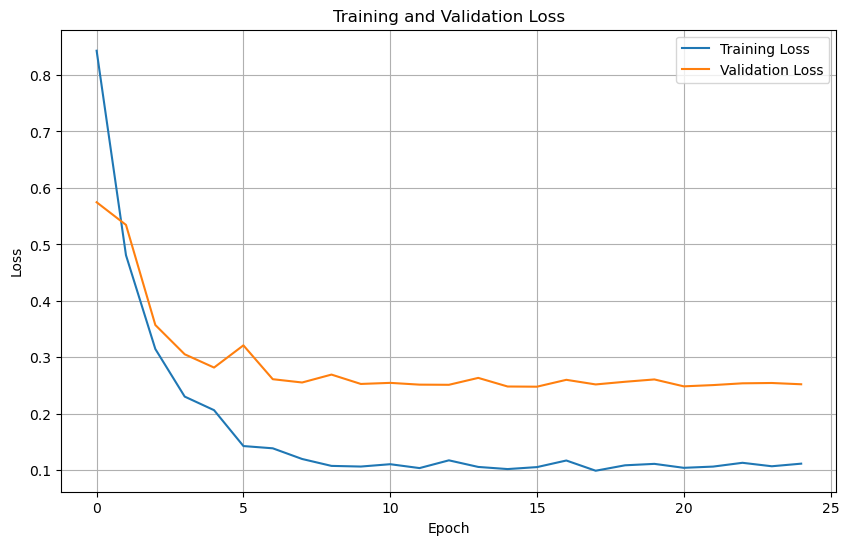

Average accuracy: 0.9560
Average precision: 0.9523
Average recall: 0.9567
Average F1 score: 0.9539
Average Time elapsed: 46.6326 seconds
Memory Usage: 18.0710 MiB


In [3]:
preTrainCPR('voltavision', 'EleComp_dataset', 5, classes)

classes:  ['semi-conductor', 'induction-coil', 'semiconductor-diode', 'stabilizer', 'pulse-generator', 'jumper-cable', 'filament', 'junction-transistor', 'LED', 'clip-lead', 'local-oscillator', 'omni-directional-antenna', 'shunt', 'Integrated-micro-circuit', 'limiter-clipper', 'solenoid', 'step-down-transformer', 'rheostat', 'electric-relay', 'memory-chip', 'PNP-transistor', 'transistor', 'relay', 'step-up-transformer', 'potential-divider', 'attenuator', 'light-circuit', 'Bypass-capacitor', 'heat-sink', 'Electrolytic-capacitor', 'multiplexer', 'cartridge-fuse', 'microchip', 'potentiometer', 'armature', 'microprocessor']
Total images:  421
Training:  336
Testing:  85
Total images:  151
Training:  120
Testing:  31
Total images:  417
Training:  333
Testing:  84
Total images:  162
Training:  129
Testing:  33
Total images:  317
Training:  253
Testing:  64
Total images:  249
Training:  199
Testing:  50
Total images:  400
Training:  320
Testing:  80
Total images:  491
Training:  392
Testing: 

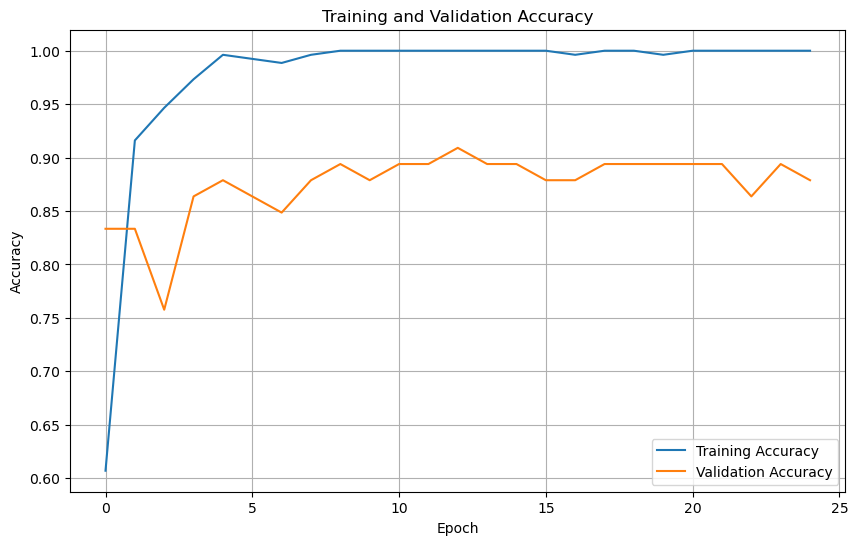

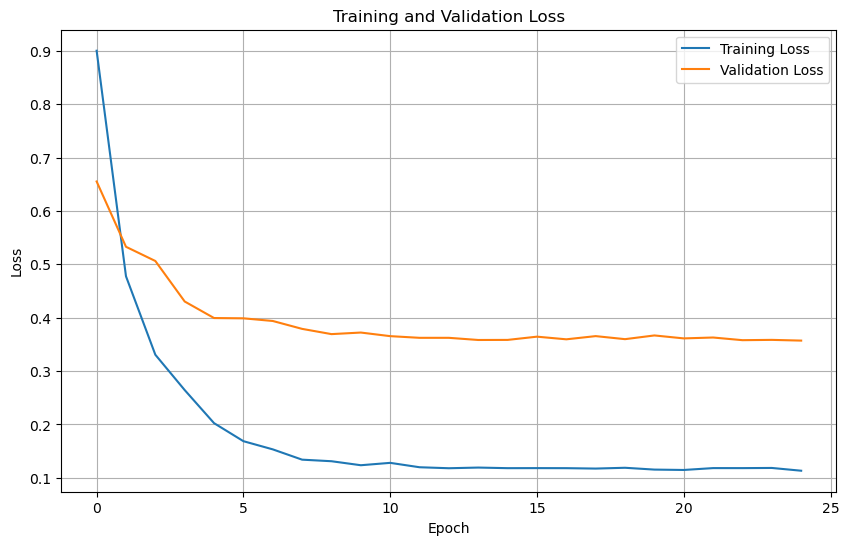

Fold:  1
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 0.8855 Acc: 0.6069
val Loss: 0.6911 Acc: 0.7424

Epoch 1/24
----------
train Loss: 0.4962 Acc: 0.8817
val Loss: 0.5407 Acc: 0.8182

Epoch 2/24
----------
train Loss: 0.3691 Acc: 0.9122
val Loss: 0.4593 Acc: 0.8636

Epoch 3/24
----------
train Loss: 0.2606 Acc: 0.9618
val Loss: 0.3941 Acc: 0.8939

Epoch 4/24
----------
train Loss: 0.2135 Acc: 0.9847
val Loss: 0.3715 Acc: 0.9091

Epoch 5/24
----------
train Loss: 0.1830 Acc: 0.9924
val Loss: 0.3504 Acc: 0.9091

Epoch 6/24
----------
train Loss: 0.1497 Acc: 0.9962
val Loss: 0.3292 Acc: 0.9091

Epoch 7/24
----------
train Loss: 0.1365 Acc: 0.9924
val Loss: 0.3258 Acc: 0.9091

Epoch 8/24
----------
train Loss: 0.1267 Acc: 1.0000
val Loss: 0.3265 Acc: 0.9091

Epoch 9/24
----------
train Loss: 0.1330 Acc: 1.0000
val Loss: 0.3246 Acc: 0.9242

Epoch 10/24
----------
train Loss: 0.1213 Acc: 1.0000
val Loss: 0.3227 Acc: 0.9242

Epoch 11/24
----------
train Loss: 0.1233 Acc:

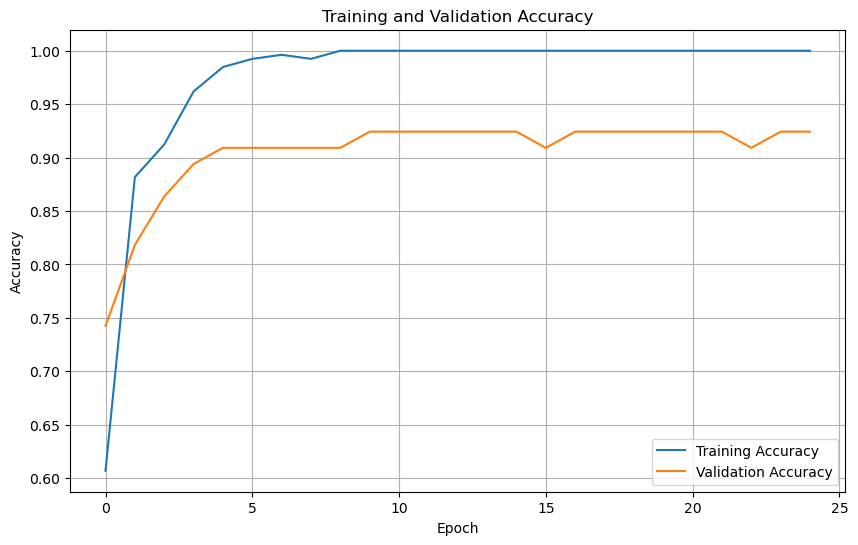

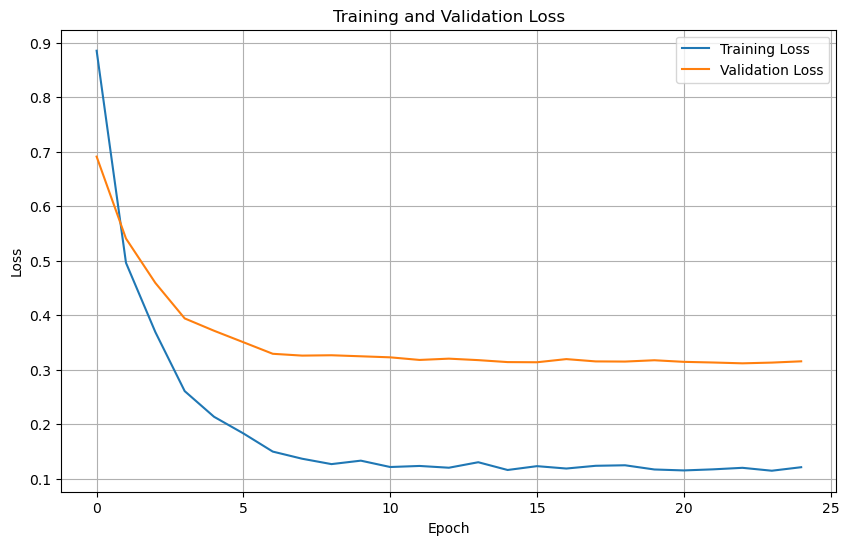

Fold:  2
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 0.8615 Acc: 0.5878
val Loss: 0.8752 Acc: 0.6061

Epoch 1/24
----------
train Loss: 0.5174 Acc: 0.8282
val Loss: 0.5465 Acc: 0.8485

Epoch 2/24
----------
train Loss: 0.3547 Acc: 0.9160
val Loss: 0.5016 Acc: 0.8333

Epoch 3/24
----------
train Loss: 0.2748 Acc: 0.9656
val Loss: 0.4234 Acc: 0.8788

Epoch 4/24
----------
train Loss: 0.2147 Acc: 0.9847
val Loss: 0.3946 Acc: 0.8788

Epoch 5/24
----------
train Loss: 0.1843 Acc: 0.9847
val Loss: 0.3816 Acc: 0.8939

Epoch 6/24
----------
train Loss: 0.1573 Acc: 0.9924
val Loss: 0.3574 Acc: 0.8788

Epoch 7/24
----------
train Loss: 0.1350 Acc: 1.0000
val Loss: 0.3560 Acc: 0.8636

Epoch 8/24
----------
train Loss: 0.1302 Acc: 1.0000
val Loss: 0.3552 Acc: 0.8788

Epoch 9/24
----------
train Loss: 0.1285 Acc: 1.0000
val Loss: 0.3618 Acc: 0.8939

Epoch 10/24
----------
train Loss: 0.1306 Acc: 1.0000
val Loss: 0.3601 Acc: 0.9091

Epoch 11/24
----------
train Loss: 0.1297 Acc:

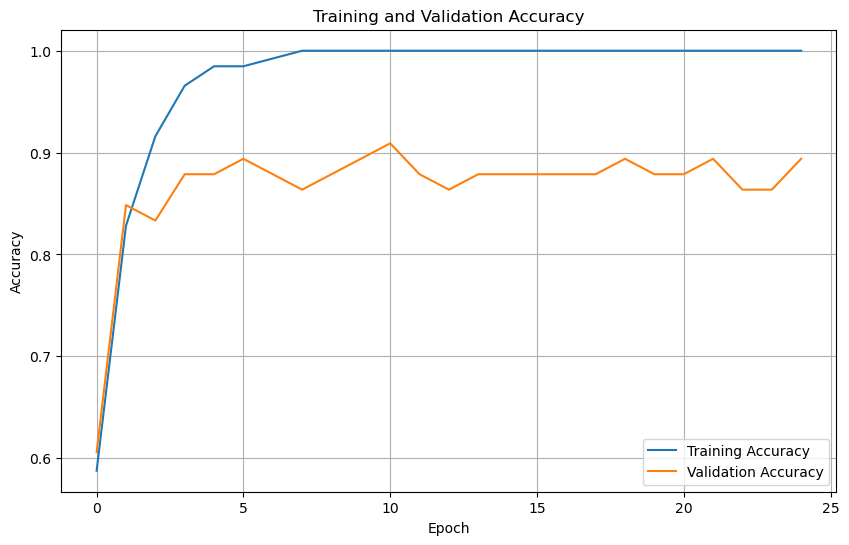

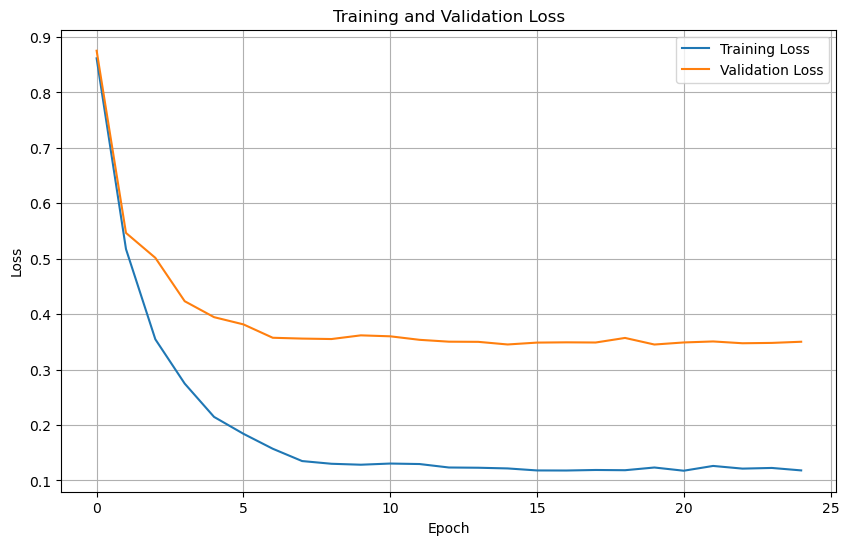

Fold:  3
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 0.8977 Acc: 0.5817
val Loss: 0.7522 Acc: 0.6615

Epoch 1/24
----------
train Loss: 0.4696 Acc: 0.9087
val Loss: 0.6041 Acc: 0.7692

Epoch 2/24
----------
train Loss: 0.3232 Acc: 0.9506
val Loss: 0.5415 Acc: 0.7846

Epoch 3/24
----------
train Loss: 0.2409 Acc: 0.9772
val Loss: 0.5636 Acc: 0.7846

Epoch 4/24
----------
train Loss: 0.2043 Acc: 0.9924
val Loss: 0.4567 Acc: 0.8923

Epoch 5/24
----------
train Loss: 0.1698 Acc: 0.9886
val Loss: 0.4486 Acc: 0.8462

Epoch 6/24
----------
train Loss: 0.1437 Acc: 1.0000
val Loss: 0.4313 Acc: 0.8615

Epoch 7/24
----------
train Loss: 0.1260 Acc: 1.0000
val Loss: 0.4294 Acc: 0.8769

Epoch 8/24
----------
train Loss: 0.1267 Acc: 1.0000
val Loss: 0.4390 Acc: 0.8462

Epoch 9/24
----------
train Loss: 0.1242 Acc: 0.9962
val Loss: 0.4292 Acc: 0.8769

Epoch 10/24
----------
train Loss: 0.1211 Acc: 1.0000
val Loss: 0.4263 Acc: 0.8769

Epoch 11/24
----------
train Loss: 0.1239 Acc:

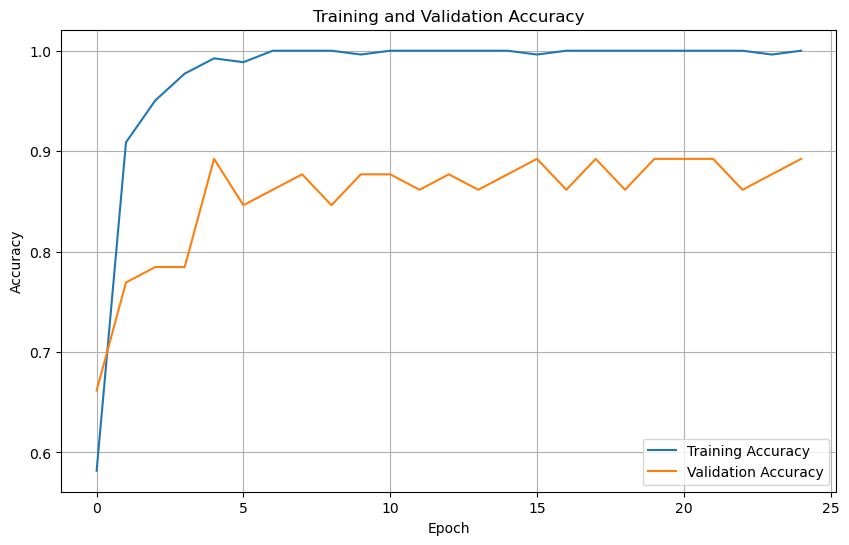

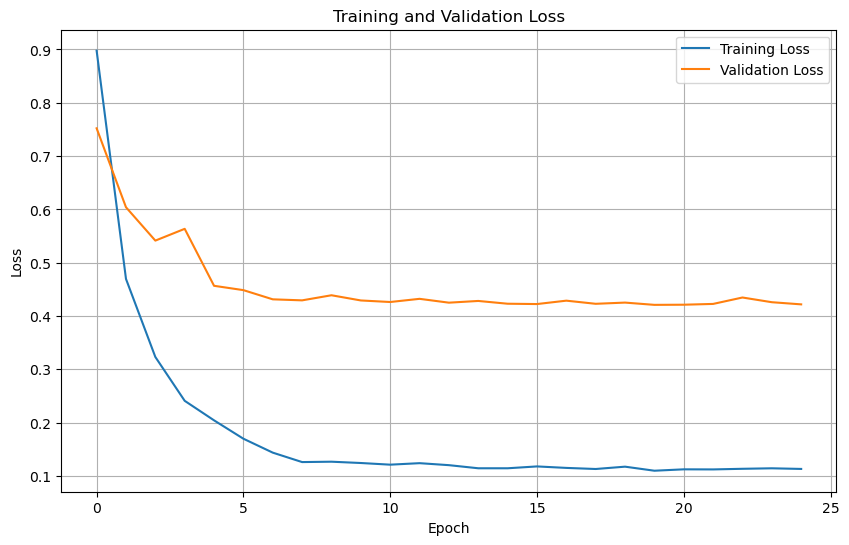

Fold:  4
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 0.9357 Acc: 0.5475
val Loss: 0.6687 Acc: 0.7538

Epoch 1/24
----------
train Loss: 0.5147 Acc: 0.8555
val Loss: 0.4954 Acc: 0.8462

Epoch 2/24
----------
train Loss: 0.3478 Acc: 0.9392
val Loss: 0.4243 Acc: 0.8615

Epoch 3/24
----------
train Loss: 0.2647 Acc: 0.9696
val Loss: 0.4011 Acc: 0.8769

Epoch 4/24
----------
train Loss: 0.2146 Acc: 0.9848
val Loss: 0.3561 Acc: 0.8615

Epoch 5/24
----------
train Loss: 0.1904 Acc: 0.9848
val Loss: 0.3304 Acc: 0.8923

Epoch 6/24
----------
train Loss: 0.1623 Acc: 0.9924
val Loss: 0.3175 Acc: 0.8923

Epoch 7/24
----------
train Loss: 0.1272 Acc: 1.0000
val Loss: 0.3118 Acc: 0.8923

Epoch 8/24
----------
train Loss: 0.1357 Acc: 0.9924
val Loss: 0.3071 Acc: 0.8923

Epoch 9/24
----------
train Loss: 0.1322 Acc: 0.9962
val Loss: 0.3081 Acc: 0.8923

Epoch 10/24
----------
train Loss: 0.1296 Acc: 1.0000
val Loss: 0.3091 Acc: 0.8923

Epoch 11/24
----------
train Loss: 0.1313 Acc:

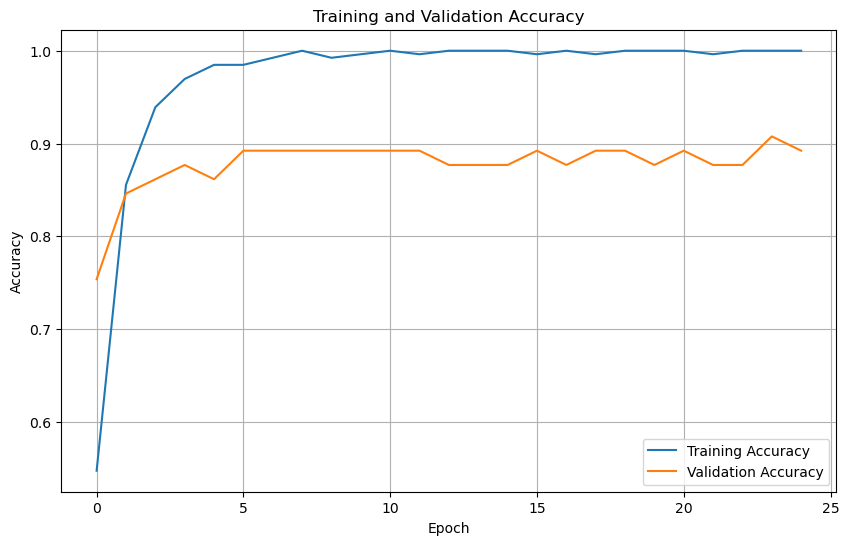

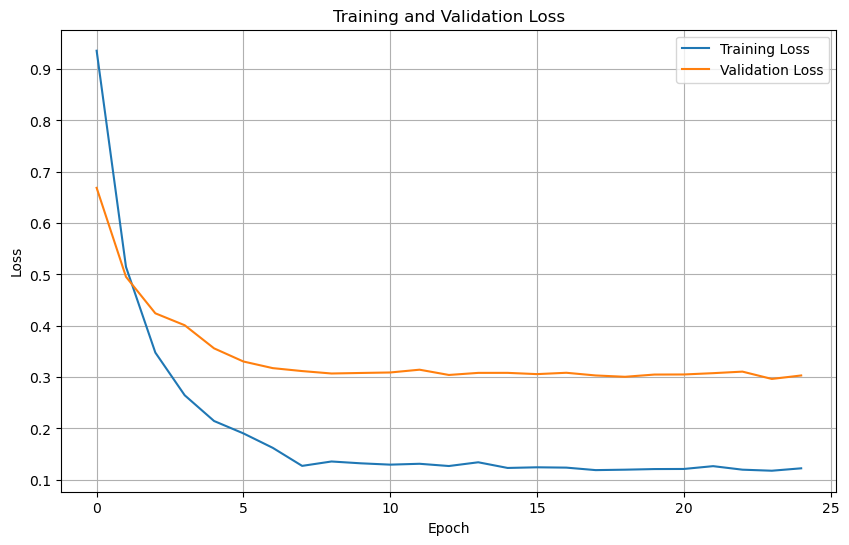

Average accuracy: 0.9360
Average precision: 0.9369
Average recall: 0.9337
Average F1 score: 0.9345
Average Time elapsed: 47.6896 seconds
Memory Usage: 18.9221 MiB


In [6]:
preTrainCPR('voltavision', 'ECD_dataset', 36, classes)

classes:  ['solenoid', 'electric-relay', 'heat-sink', 'Electrolytic-capacitor', 'potentiometer']
Total images:  317
Training:  253
Testing:  64
Total images:  420
Training:  336
Testing:  84
Total images:  420
Training:  336
Testing:  84
Total images:  403
Training:  322
Testing:  81
Total images:  468
Training:  374
Testing:  94
train_count:  1621
test_count:  407
Epoch: 0 Train Loss: tensor(2.0901) Train Accuracy: 0.43861813695249846 Test Accuracy: 1.9877149877149878
Epoch: 1 Train Loss: tensor(1.5054) Train Accuracy: 0.6576187538556446 Test Accuracy: 2.6584766584766584
Epoch: 2 Train Loss: tensor(1.2615) Train Accuracy: 0.7853177051202961 Test Accuracy: 2.8746928746928746
Epoch: 3 Train Loss: tensor(1.0347) Train Accuracy: 0.8827884022208513 Test Accuracy: 3.1793611793611793
Epoch: 4 Train Loss: tensor(0.8901) Train Accuracy: 0.9555829734731647 Test Accuracy: 3.2555282555282554
Epoch: 5 Train Loss: tensor(0.6384) Train Accuracy: 1.0894509561998766 Test Accuracy: 3.764127764127764
Ep

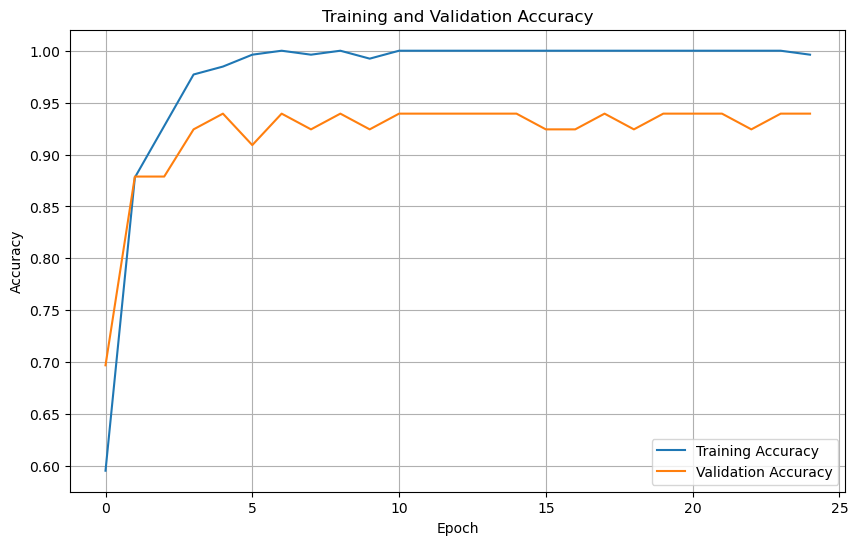

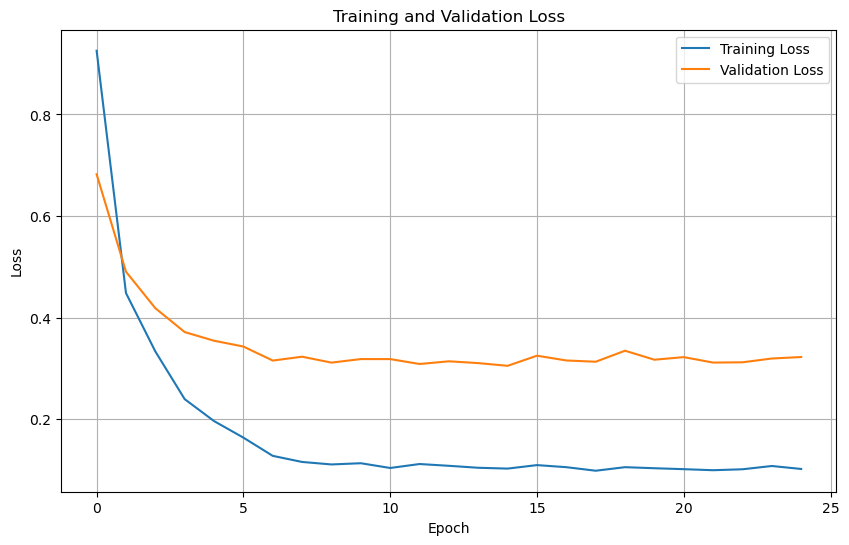

Fold:  1
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 0.9205 Acc: 0.5611
val Loss: 0.6332 Acc: 0.6970

Epoch 1/24
----------
train Loss: 0.4376 Acc: 0.9122
val Loss: 0.4770 Acc: 0.8636

Epoch 2/24
----------
train Loss: 0.3135 Acc: 0.9427
val Loss: 0.4066 Acc: 0.8788

Epoch 3/24
----------
train Loss: 0.2440 Acc: 0.9656
val Loss: 0.3753 Acc: 0.9091

Epoch 4/24
----------
train Loss: 0.1889 Acc: 0.9885
val Loss: 0.3666 Acc: 0.9091

Epoch 5/24
----------
train Loss: 0.1496 Acc: 0.9962
val Loss: 0.3117 Acc: 0.9091

Epoch 6/24
----------
train Loss: 0.1282 Acc: 0.9962
val Loss: 0.3311 Acc: 0.9091

Epoch 7/24
----------
train Loss: 0.1146 Acc: 0.9924
val Loss: 0.3008 Acc: 0.9091

Epoch 8/24
----------
train Loss: 0.1138 Acc: 0.9962
val Loss: 0.2990 Acc: 0.9091

Epoch 9/24
----------
train Loss: 0.1133 Acc: 1.0000
val Loss: 0.2959 Acc: 0.9091

Epoch 10/24
----------
train Loss: 0.1063 Acc: 1.0000
val Loss: 0.3007 Acc: 0.9091

Epoch 11/24
----------
train Loss: 0.1051 Acc:

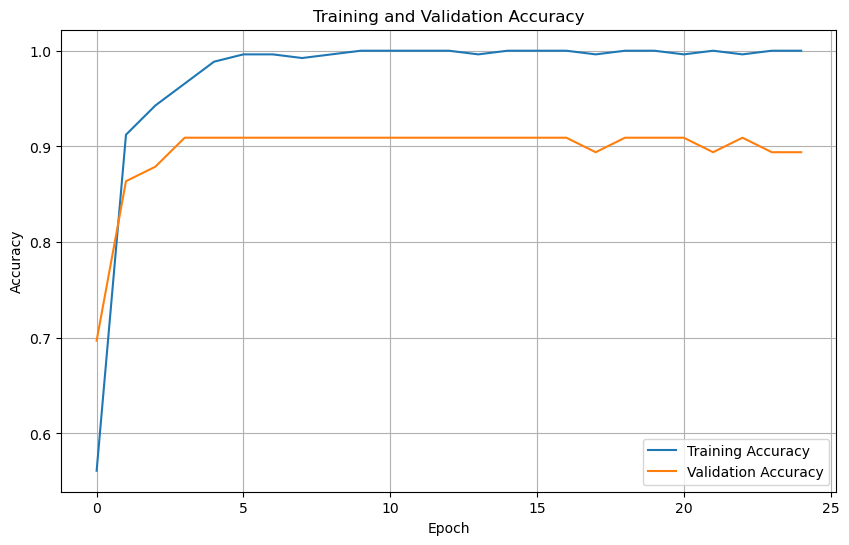

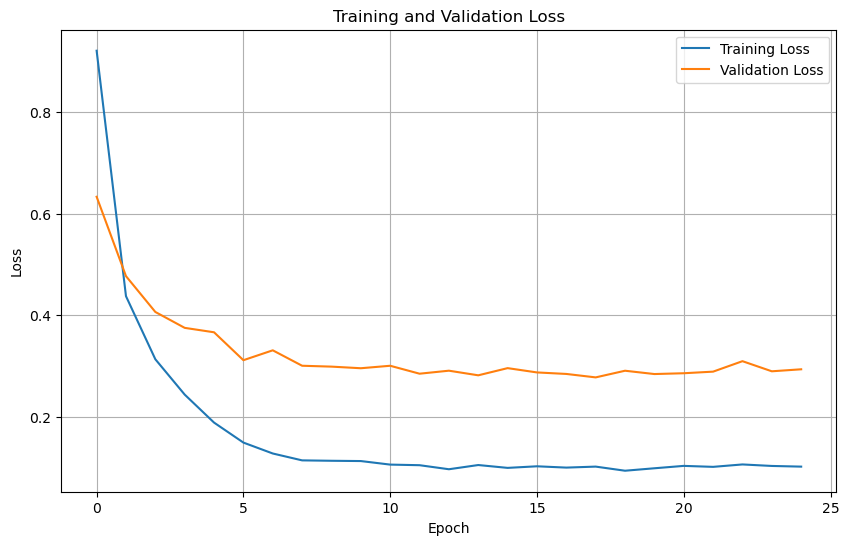

Fold:  2
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 0.8721 Acc: 0.6221
val Loss: 0.7080 Acc: 0.7576

Epoch 1/24
----------
train Loss: 0.4567 Acc: 0.8855
val Loss: 0.5208 Acc: 0.8030

Epoch 2/24
----------
train Loss: 0.3026 Acc: 0.9313
val Loss: 0.4743 Acc: 0.8788

Epoch 3/24
----------
train Loss: 0.2274 Acc: 0.9771
val Loss: 0.4948 Acc: 0.7879

Epoch 4/24
----------
train Loss: 0.1852 Acc: 0.9847
val Loss: 0.4058 Acc: 0.8636

Epoch 5/24
----------
train Loss: 0.1431 Acc: 0.9924
val Loss: 0.3920 Acc: 0.8788

Epoch 6/24
----------
train Loss: 0.1241 Acc: 0.9962
val Loss: 0.3770 Acc: 0.8788

Epoch 7/24
----------
train Loss: 0.1033 Acc: 1.0000
val Loss: 0.3764 Acc: 0.8788

Epoch 8/24
----------
train Loss: 0.1105 Acc: 0.9962
val Loss: 0.3720 Acc: 0.8788

Epoch 9/24
----------
train Loss: 0.1056 Acc: 1.0000
val Loss: 0.3727 Acc: 0.8939

Epoch 10/24
----------
train Loss: 0.1085 Acc: 1.0000
val Loss: 0.3751 Acc: 0.8788

Epoch 11/24
----------
train Loss: 0.1052 Acc:

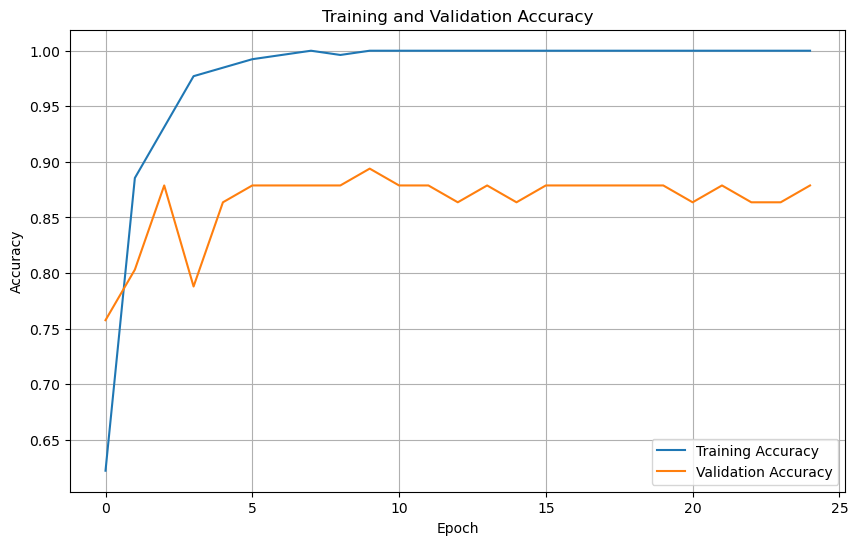

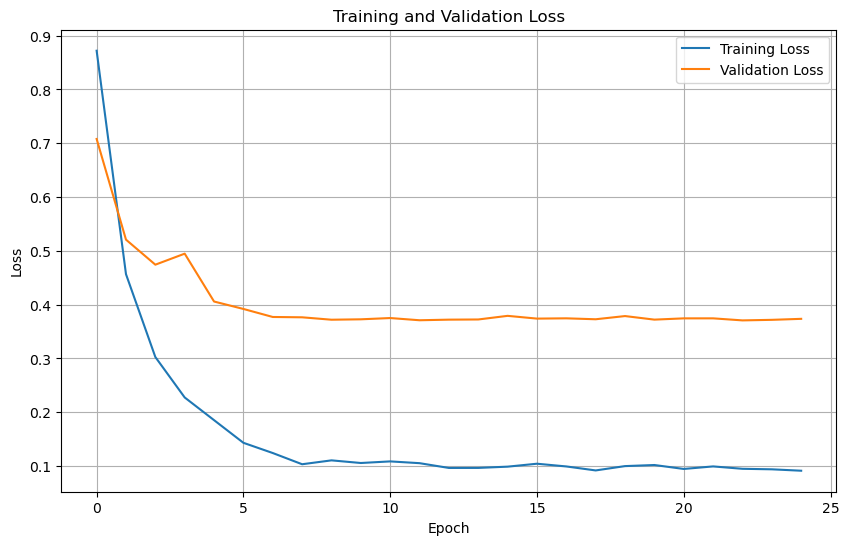

Fold:  3
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 0.8969 Acc: 0.5741
val Loss: 0.5650 Acc: 0.9077

Epoch 1/24
----------
train Loss: 0.4608 Acc: 0.8821
val Loss: 0.4663 Acc: 0.9231

Epoch 2/24
----------
train Loss: 0.2832 Acc: 0.9848
val Loss: 0.3987 Acc: 0.9077

Epoch 3/24
----------
train Loss: 0.2387 Acc: 0.9810
val Loss: 0.3835 Acc: 0.9077

Epoch 4/24
----------
train Loss: 0.1768 Acc: 0.9810
val Loss: 0.3668 Acc: 0.9077

Epoch 5/24
----------
train Loss: 0.1480 Acc: 0.9962
val Loss: 0.3517 Acc: 0.9077

Epoch 6/24
----------
train Loss: 0.1240 Acc: 1.0000
val Loss: 0.3389 Acc: 0.9077

Epoch 7/24
----------
train Loss: 0.1039 Acc: 1.0000
val Loss: 0.3453 Acc: 0.9077

Epoch 8/24
----------
train Loss: 0.1033 Acc: 1.0000
val Loss: 0.3441 Acc: 0.9077

Epoch 9/24
----------
train Loss: 0.1044 Acc: 1.0000
val Loss: 0.3397 Acc: 0.9077

Epoch 10/24
----------
train Loss: 0.0990 Acc: 1.0000
val Loss: 0.3449 Acc: 0.9077

Epoch 11/24
----------
train Loss: 0.1023 Acc:

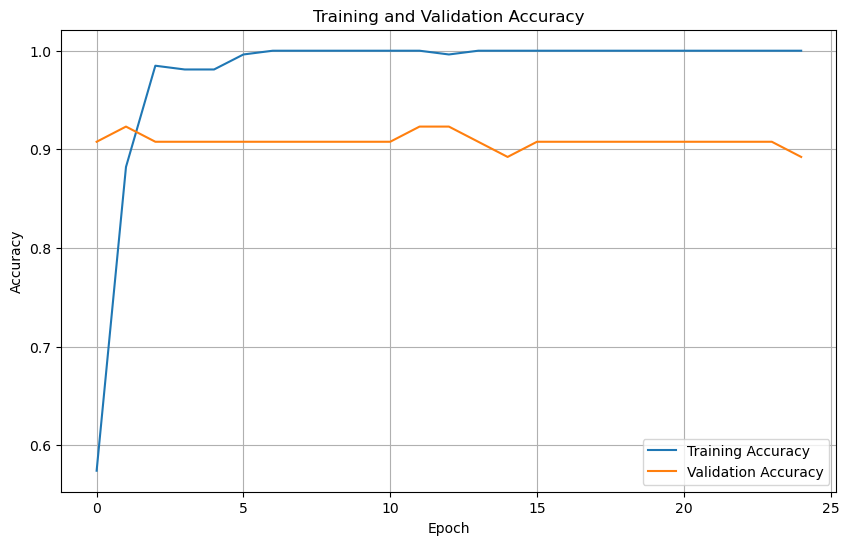

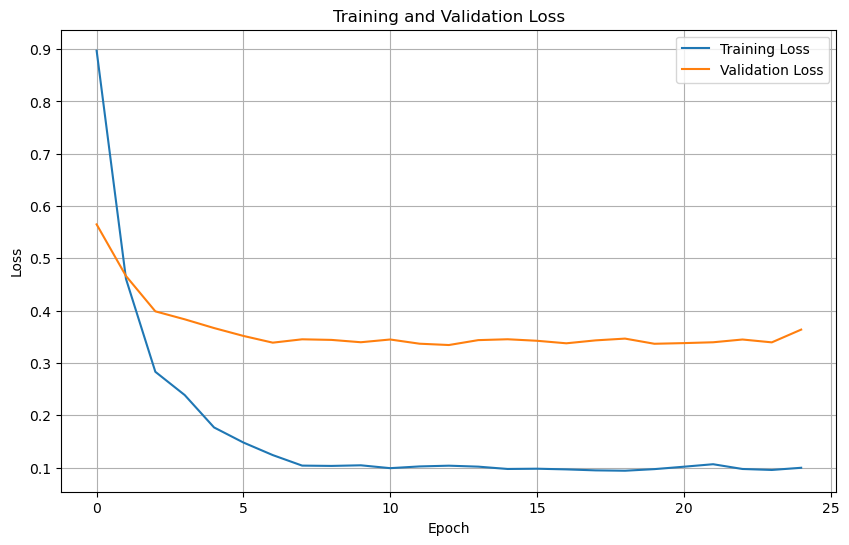

Fold:  4
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 0.9285 Acc: 0.5589
val Loss: 0.6735 Acc: 0.7538

Epoch 1/24
----------
train Loss: 0.4870 Acc: 0.8707
val Loss: 0.4876 Acc: 0.8769

Epoch 2/24
----------
train Loss: 0.3137 Acc: 0.9696
val Loss: 0.4277 Acc: 0.8308

Epoch 3/24
----------
train Loss: 0.2426 Acc: 0.9696
val Loss: 0.3829 Acc: 0.8923

Epoch 4/24
----------
train Loss: 0.2037 Acc: 0.9810
val Loss: 0.3747 Acc: 0.8923

Epoch 5/24
----------
train Loss: 0.1675 Acc: 0.9886
val Loss: 0.3217 Acc: 0.9077

Epoch 6/24
----------
train Loss: 0.1300 Acc: 0.9924
val Loss: 0.3150 Acc: 0.9077

Epoch 7/24
----------
train Loss: 0.1118 Acc: 1.0000
val Loss: 0.3130 Acc: 0.9077

Epoch 8/24
----------
train Loss: 0.1161 Acc: 1.0000
val Loss: 0.3178 Acc: 0.9077

Epoch 9/24
----------
train Loss: 0.1077 Acc: 1.0000
val Loss: 0.3125 Acc: 0.9077

Epoch 10/24
----------
train Loss: 0.1084 Acc: 1.0000
val Loss: 0.3134 Acc: 0.8923

Epoch 11/24
----------
train Loss: 0.1101 Acc:

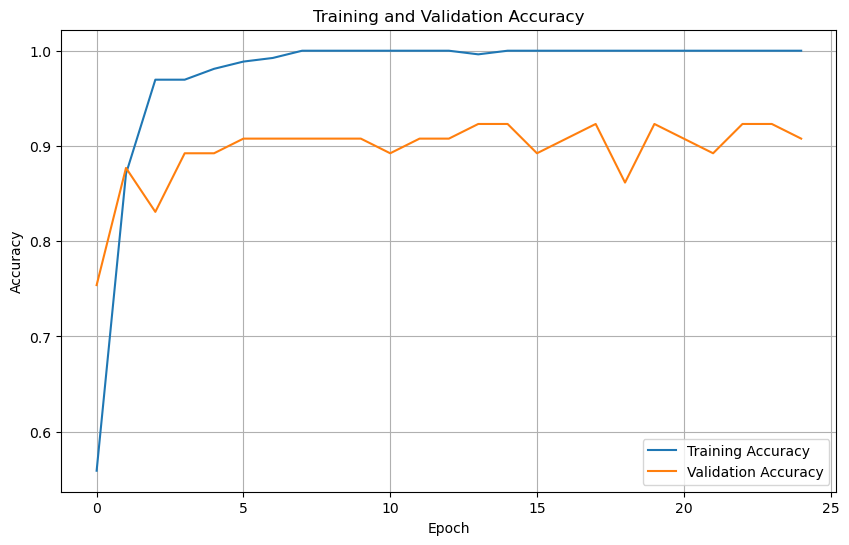

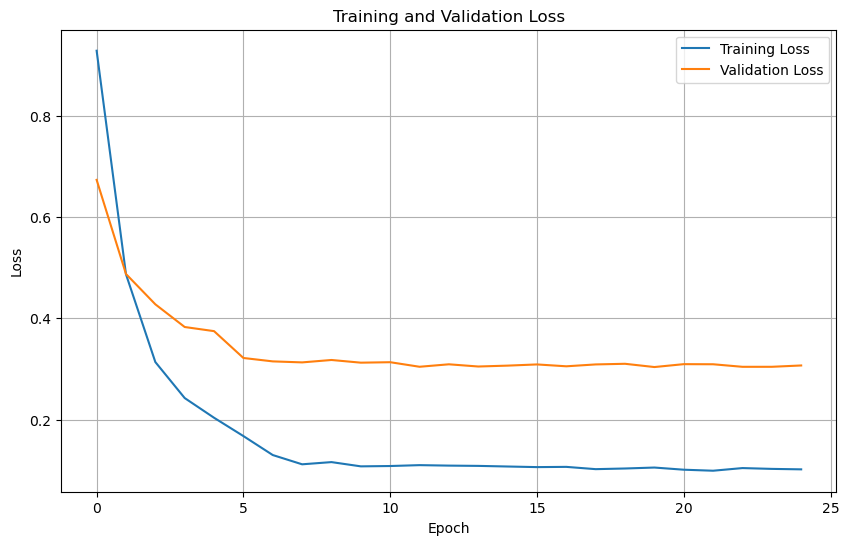

Average accuracy: 0.9380
Average precision: 0.9367
Average recall: 0.9368
Average F1 score: 0.9361
Average Time elapsed: 46.8702 seconds
Memory Usage: 18.0710 MiB


In [8]:
preTrainCPR('voltavision', 'EleComp_dataset', 5, classes)

classes:  ['3', '1', '2']
Total images:  626
Training:  500
Testing:  126
Total images:  596
Training:  476
Testing:  120
Total images:  588
Training:  470
Testing:  118
train_count:  1446
test_count:  364
Epoch: 0 Train Loss: tensor(0.7225) Train Accuracy: 0.9384508990318119 Test Accuracy: 2.019230769230769
Epoch: 1 Train Loss: tensor(0.1537) Train Accuracy: 1.2005532503457814 Test Accuracy: 2.912087912087912
Epoch: 2 Train Loss: tensor(0.0585) Train Accuracy: 1.2351313969571232 Test Accuracy: 2.9725274725274726
Epoch: 3 Train Loss: tensor(0.0430) Train Accuracy: 1.239972337482711 Test Accuracy: 2.9175824175824174
Epoch: 4 Train Loss: tensor(0.0515) Train Accuracy: 1.23582295988935 Test Accuracy: 2.9752747252747254
Epoch: 5 Train Loss: tensor(0.0196) Train Accuracy: 1.248271092669433 Test Accuracy: 2.9752747252747254
Epoch: 6 Train Loss: tensor(0.0134) Train Accuracy: 1.2489626556016598 Test Accuracy: 2.9752747252747254
Epoch: 7 Train Loss: tensor(0.0128) Train Accuracy: 1.24896265560

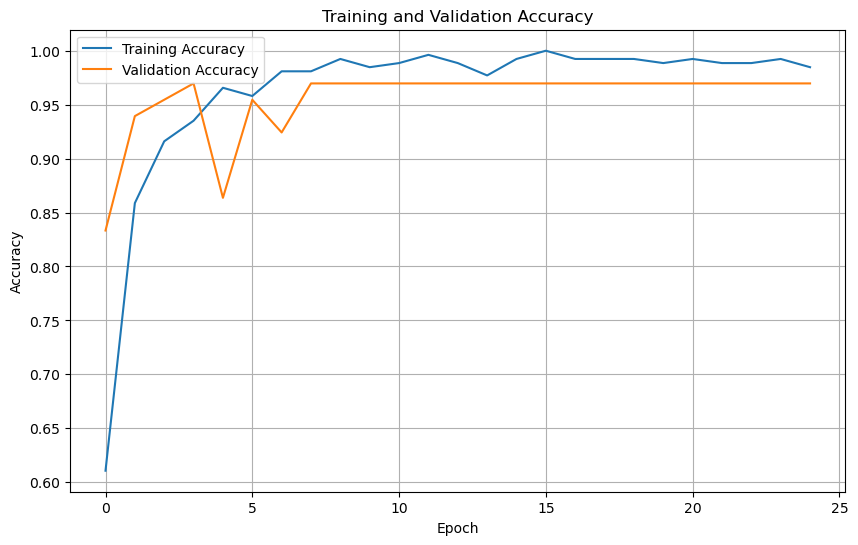

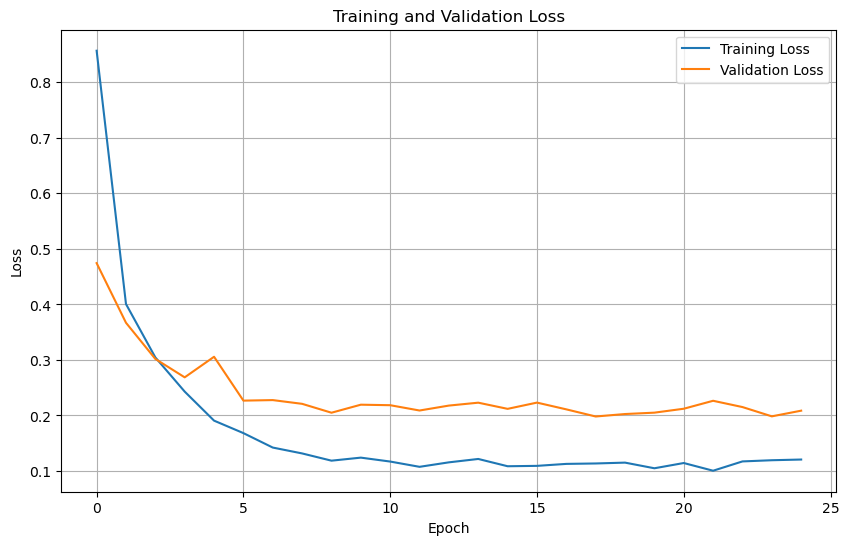

Fold:  1
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 0.7452 Acc: 0.6870
val Loss: 0.7328 Acc: 0.6818

Epoch 1/24
----------
train Loss: 0.4341 Acc: 0.8550
val Loss: 0.3974 Acc: 0.8182

Epoch 2/24
----------
train Loss: 0.3065 Acc: 0.9122
val Loss: 0.3571 Acc: 0.8485

Epoch 3/24
----------
train Loss: 0.2219 Acc: 0.9504
val Loss: 0.3034 Acc: 0.8788

Epoch 4/24
----------
train Loss: 0.1788 Acc: 0.9733
val Loss: 0.2600 Acc: 0.9091

Epoch 5/24
----------
train Loss: 0.1627 Acc: 0.9771
val Loss: 0.2314 Acc: 0.9394

Epoch 6/24
----------
train Loss: 0.1496 Acc: 0.9771
val Loss: 0.2452 Acc: 0.9091

Epoch 7/24
----------
train Loss: 0.1334 Acc: 0.9809
val Loss: 0.2246 Acc: 0.9394

Epoch 8/24
----------
train Loss: 0.1173 Acc: 0.9924
val Loss: 0.2175 Acc: 0.9394

Epoch 9/24
----------
train Loss: 0.1174 Acc: 0.9885
val Loss: 0.2255 Acc: 0.9394

Epoch 10/24
----------
train Loss: 0.1219 Acc: 0.9885
val Loss: 0.2235 Acc: 0.9394

Epoch 11/24
----------
train Loss: 0.1205 Acc:

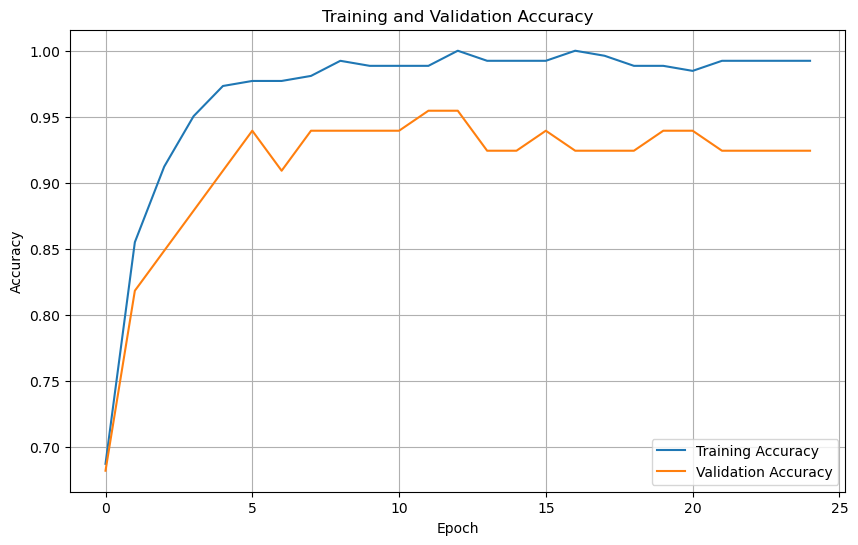

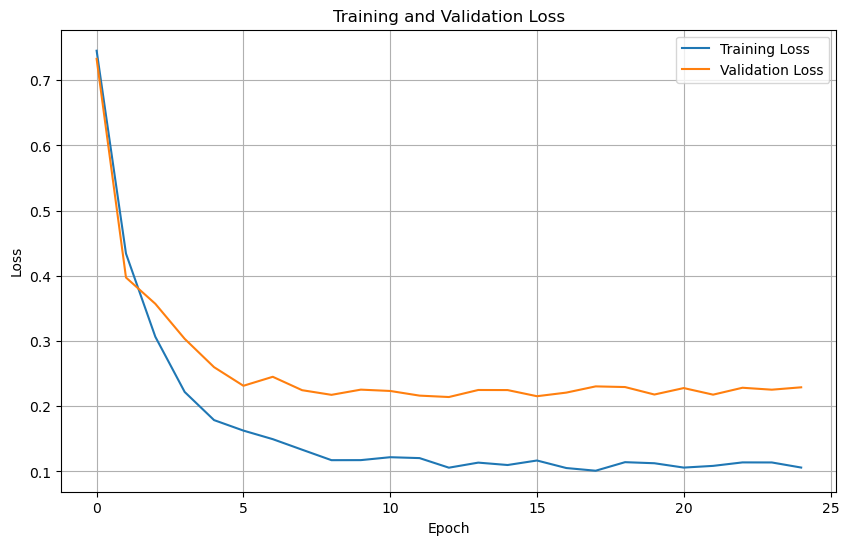

Fold:  2
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 0.7565 Acc: 0.6679
val Loss: 0.6370 Acc: 0.6667

Epoch 1/24
----------
train Loss: 0.3868 Acc: 0.8702
val Loss: 0.3599 Acc: 0.9242

Epoch 2/24
----------
train Loss: 0.3008 Acc: 0.9313
val Loss: 0.2898 Acc: 0.9091

Epoch 3/24
----------
train Loss: 0.2090 Acc: 0.9580
val Loss: 0.2992 Acc: 0.9242

Epoch 4/24
----------
train Loss: 0.2133 Acc: 0.9351
val Loss: 0.2607 Acc: 0.9242

Epoch 5/24
----------
train Loss: 0.1672 Acc: 0.9656
val Loss: 0.2574 Acc: 0.8939

Epoch 6/24
----------
train Loss: 0.1329 Acc: 0.9847
val Loss: 0.2344 Acc: 0.9545

Epoch 7/24
----------
train Loss: 0.1159 Acc: 0.9885
val Loss: 0.2328 Acc: 0.9394

Epoch 8/24
----------
train Loss: 0.1186 Acc: 0.9924
val Loss: 0.2289 Acc: 0.9545

Epoch 9/24
----------
train Loss: 0.1161 Acc: 0.9962
val Loss: 0.2182 Acc: 0.9545

Epoch 10/24
----------
train Loss: 0.1170 Acc: 0.9847
val Loss: 0.2190 Acc: 0.9394

Epoch 11/24
----------
train Loss: 0.1116 Acc:

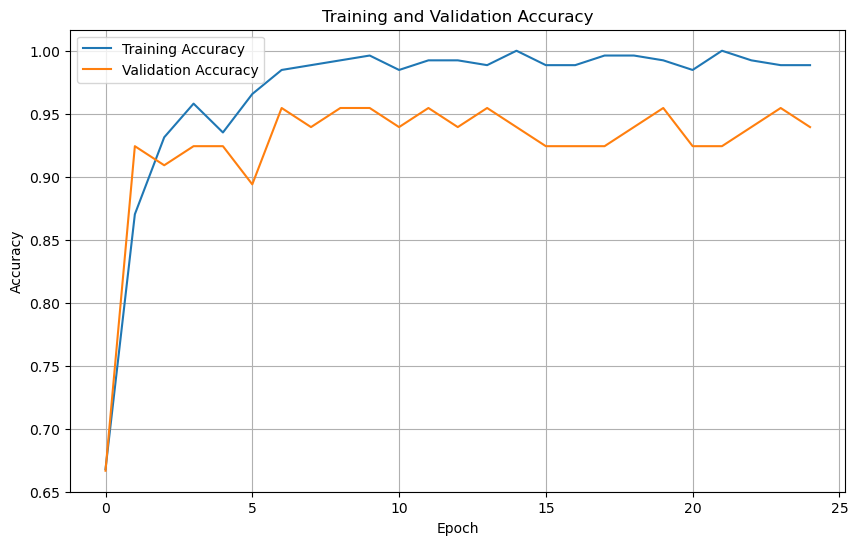

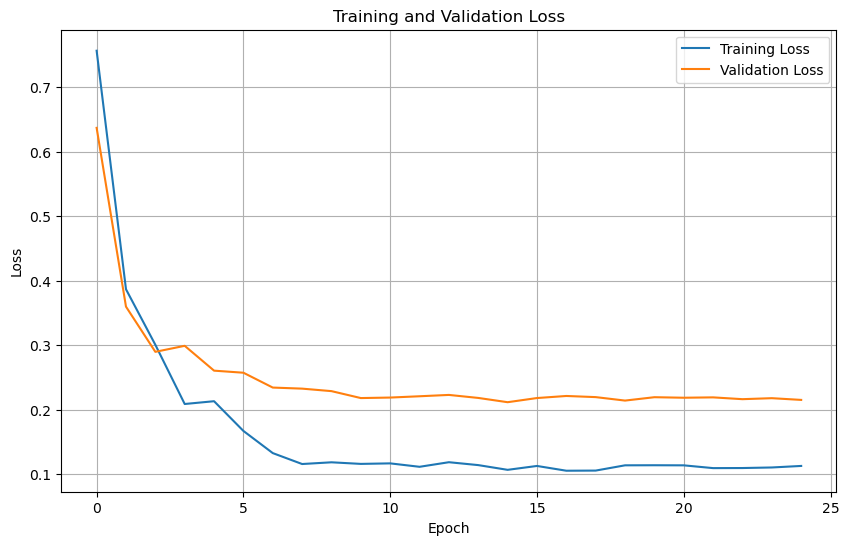

Fold:  3
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 0.7780 Acc: 0.6578
val Loss: 0.5510 Acc: 0.7231

Epoch 1/24
----------
train Loss: 0.3955 Acc: 0.8669
val Loss: 0.3437 Acc: 0.9385

Epoch 2/24
----------
train Loss: 0.2879 Acc: 0.9163
val Loss: 0.2987 Acc: 0.9538

Epoch 3/24
----------
train Loss: 0.2236 Acc: 0.9392
val Loss: 0.2649 Acc: 0.9692

Epoch 4/24
----------
train Loss: 0.1761 Acc: 0.9734
val Loss: 0.2477 Acc: 0.9846

Epoch 5/24
----------
train Loss: 0.1733 Acc: 0.9734
val Loss: 0.2621 Acc: 0.9538

Epoch 6/24
----------
train Loss: 0.1430 Acc: 0.9810
val Loss: 0.2419 Acc: 0.9538

Epoch 7/24
----------
train Loss: 0.1219 Acc: 0.9810
val Loss: 0.2327 Acc: 0.9846

Epoch 8/24
----------
train Loss: 0.1100 Acc: 0.9848
val Loss: 0.2365 Acc: 0.9846

Epoch 9/24
----------
train Loss: 0.1169 Acc: 0.9924
val Loss: 0.2309 Acc: 0.9846

Epoch 10/24
----------
train Loss: 0.1109 Acc: 0.9924
val Loss: 0.2338 Acc: 0.9846

Epoch 11/24
----------
train Loss: 0.1094 Acc:

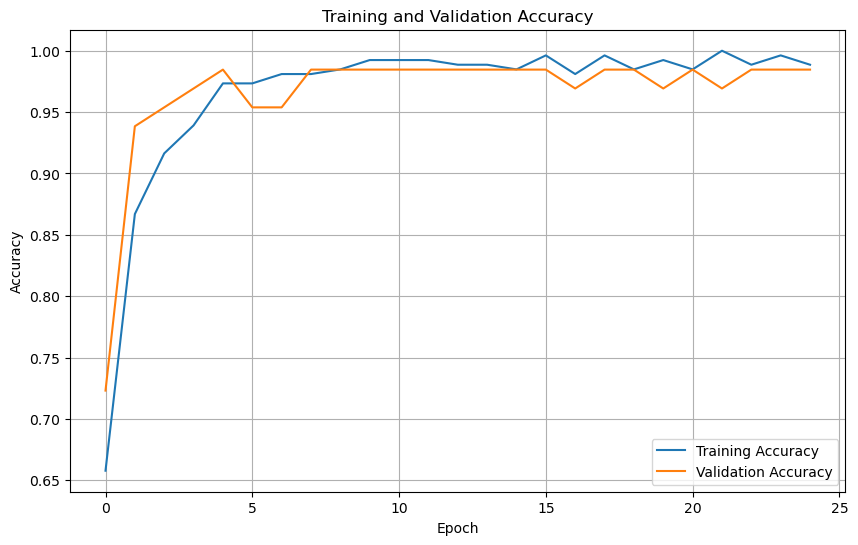

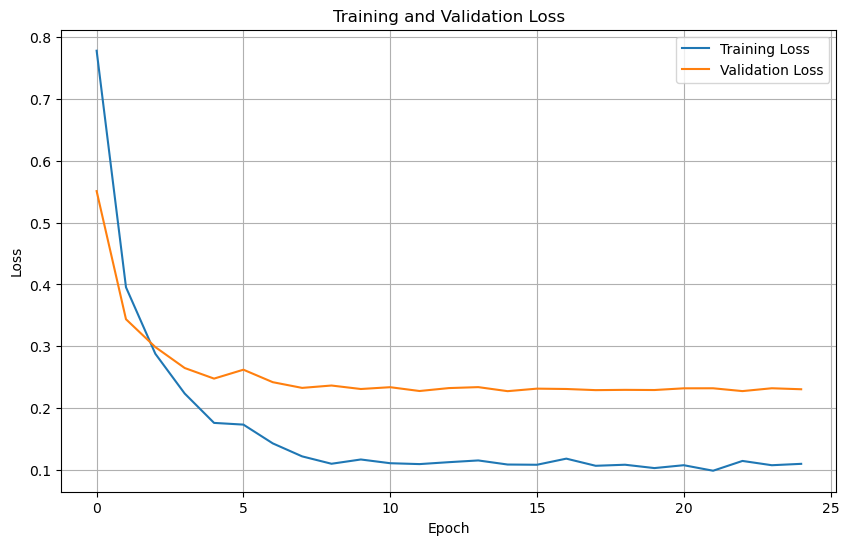

Fold:  4
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 0.7891 Acc: 0.6274
val Loss: 0.6052 Acc: 0.7231

Epoch 1/24
----------
train Loss: 0.4000 Acc: 0.8707
val Loss: 0.3222 Acc: 0.9385

Epoch 2/24
----------
train Loss: 0.2706 Acc: 0.9430
val Loss: 0.4197 Acc: 0.8000

Epoch 3/24
----------
train Loss: 0.2405 Acc: 0.9430
val Loss: 0.2793 Acc: 0.8923

Epoch 4/24
----------
train Loss: 0.2085 Acc: 0.9734
val Loss: 0.2457 Acc: 0.9385

Epoch 5/24
----------
train Loss: 0.1738 Acc: 0.9734
val Loss: 0.2340 Acc: 0.9385

Epoch 6/24
----------
train Loss: 0.1444 Acc: 0.9734
val Loss: 0.2221 Acc: 0.9538

Epoch 7/24
----------
train Loss: 0.1185 Acc: 0.9924
val Loss: 0.2255 Acc: 0.9385

Epoch 8/24
----------
train Loss: 0.1196 Acc: 0.9924
val Loss: 0.2259 Acc: 0.9231

Epoch 9/24
----------
train Loss: 0.1168 Acc: 0.9886
val Loss: 0.2204 Acc: 0.9538

Epoch 10/24
----------
train Loss: 0.1080 Acc: 1.0000
val Loss: 0.2187 Acc: 0.9538

Epoch 11/24
----------
train Loss: 0.1113 Acc:

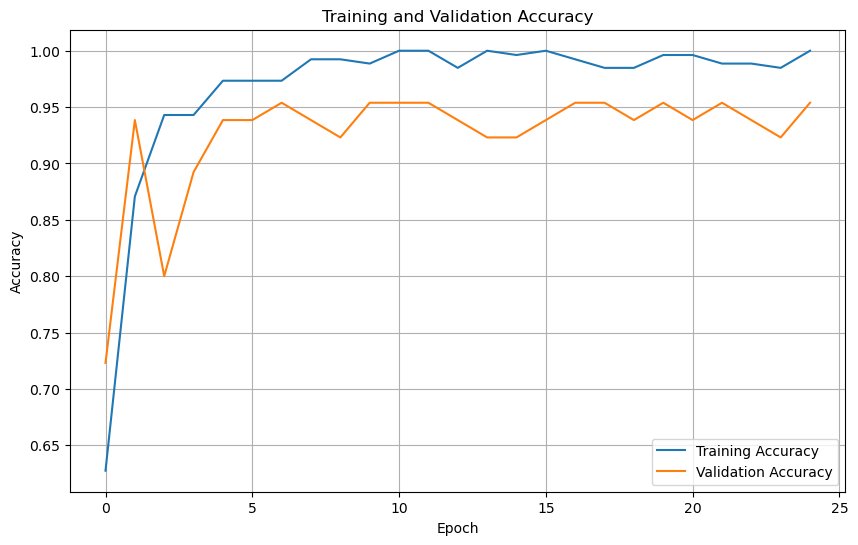

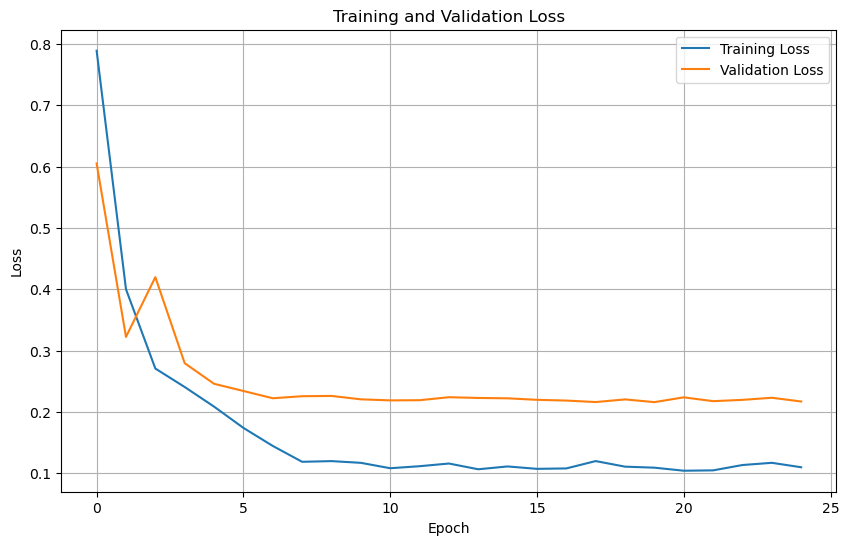

Average accuracy: 0.9520
Average precision: 0.9521
Average recall: 0.9525
Average F1 score: 0.9520
Average Time elapsed: 46.6625 seconds
Memory Usage: 18.0158 MiB


In [11]:
preTrainCPR('voltavision', 'CPR_dataset', 3, classes)

classes:  ['solenoid', 'electric-relay', 'heat-sink', 'Electrolytic-capacitor', 'potentiometer']
Total images:  317
Training:  253
Testing:  64
Total images:  420
Training:  336
Testing:  84
Total images:  420
Training:  336
Testing:  84
Total images:  403
Training:  322
Testing:  81
Total images:  468
Training:  374
Testing:  94
train_count:  1621
test_count:  407
Epoch: 0 Train Loss: tensor(2.1253) Train Accuracy: 0.4268969771745836 Test Accuracy: 1.7641277641277642
Epoch: 1 Train Loss: tensor(1.5325) Train Accuracy: 0.6514497223935842 Test Accuracy: 2.7592137592137593
Epoch: 2 Train Loss: tensor(1.2626) Train Accuracy: 0.783466995681678 Test Accuracy: 3.203931203931204
Epoch: 3 Train Loss: tensor(1.0583) Train Accuracy: 0.8661320172732881 Test Accuracy: 3.3538083538083536
Epoch: 4 Train Loss: tensor(0.8655) Train Accuracy: 0.9568167797655768 Test Accuracy: 3.7174447174447174
Epoch: 5 Train Loss: tensor(0.6213) Train Accuracy: 1.107958050586058 Test Accuracy: 3.8746928746928746
Epoch

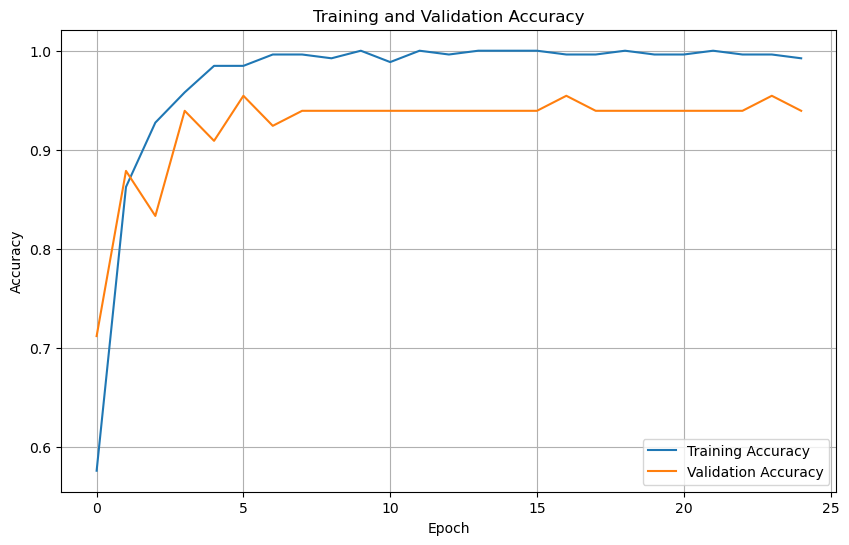

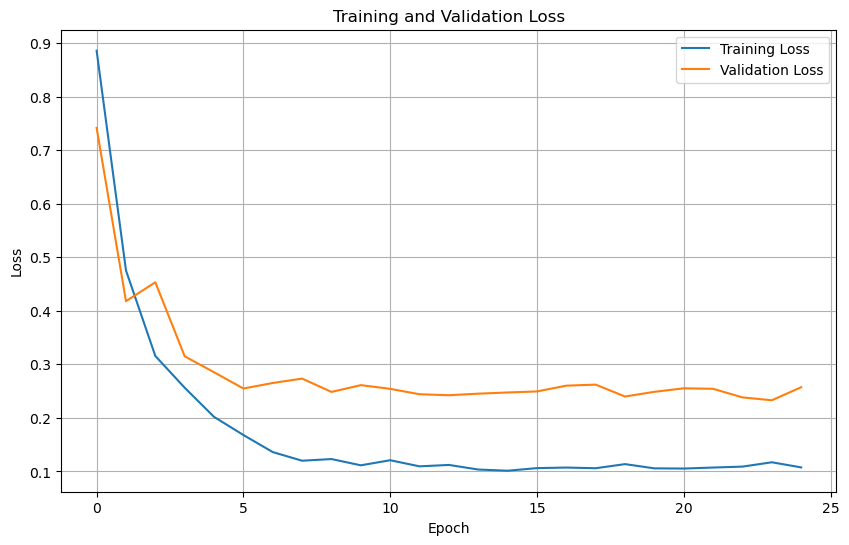

Fold:  1
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 0.8984 Acc: 0.5496
val Loss: 0.6494 Acc: 0.7121

Epoch 1/24
----------
train Loss: 0.4403 Acc: 0.8588
val Loss: 0.7186 Acc: 0.7121

Epoch 2/24
----------
train Loss: 0.3320 Acc: 0.9313
val Loss: 0.5649 Acc: 0.7727

Epoch 3/24
----------
train Loss: 0.2258 Acc: 0.9733
val Loss: 0.3947 Acc: 0.8485

Epoch 4/24
----------
train Loss: 0.1905 Acc: 0.9809
val Loss: 0.3862 Acc: 0.8333

Epoch 5/24
----------
train Loss: 0.1666 Acc: 0.9885
val Loss: 0.3355 Acc: 0.8788

Epoch 6/24
----------
train Loss: 0.1435 Acc: 0.9962
val Loss: 0.3093 Acc: 0.8939

Epoch 7/24
----------
train Loss: 0.1087 Acc: 1.0000
val Loss: 0.3028 Acc: 0.8939

Epoch 8/24
----------
train Loss: 0.1085 Acc: 1.0000
val Loss: 0.3160 Acc: 0.9091

Epoch 9/24
----------
train Loss: 0.1099 Acc: 1.0000
val Loss: 0.3153 Acc: 0.9091

Epoch 10/24
----------
train Loss: 0.1134 Acc: 1.0000
val Loss: 0.3077 Acc: 0.9091

Epoch 11/24
----------
train Loss: 0.1142 Acc:

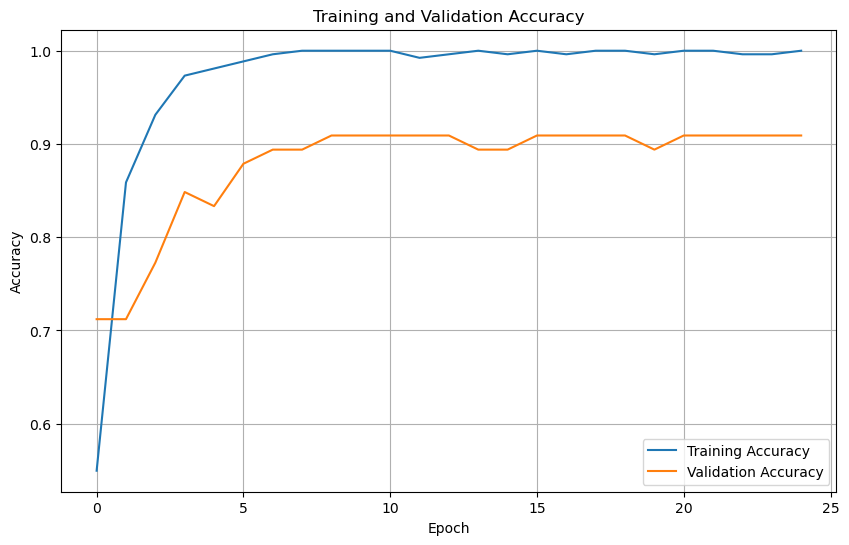

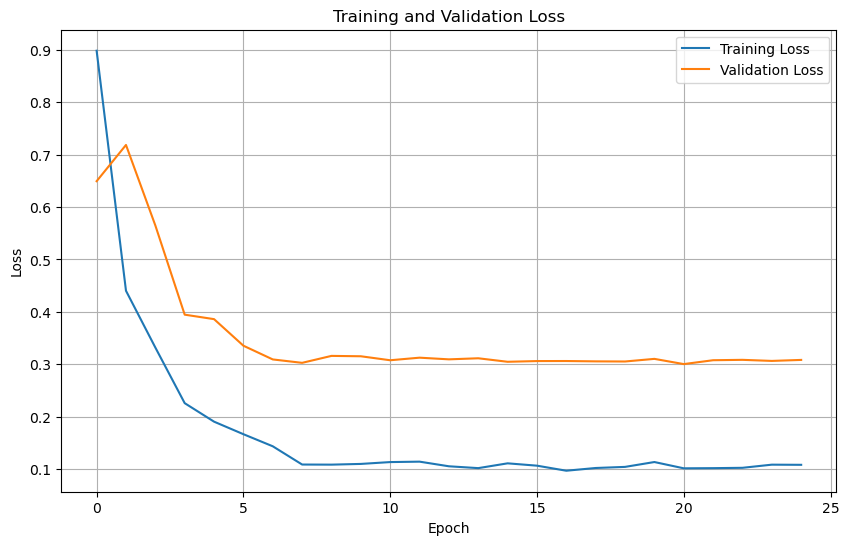

Fold:  2
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 0.8834 Acc: 0.5916
val Loss: 0.6941 Acc: 0.6364

Epoch 1/24
----------
train Loss: 0.4649 Acc: 0.8588
val Loss: 0.5814 Acc: 0.7879

Epoch 2/24
----------
train Loss: 0.3110 Acc: 0.9389
val Loss: 0.4564 Acc: 0.8788

Epoch 3/24
----------
train Loss: 0.2322 Acc: 0.9656
val Loss: 0.4111 Acc: 0.8485

Epoch 4/24
----------
train Loss: 0.2034 Acc: 0.9695
val Loss: 0.3871 Acc: 0.9091

Epoch 5/24
----------
train Loss: 0.1560 Acc: 0.9847
val Loss: 0.3570 Acc: 0.8636

Epoch 6/24
----------
train Loss: 0.1367 Acc: 0.9885
val Loss: 0.3468 Acc: 0.8939

Epoch 7/24
----------
train Loss: 0.1167 Acc: 0.9962
val Loss: 0.3389 Acc: 0.8939

Epoch 8/24
----------
train Loss: 0.1127 Acc: 0.9924
val Loss: 0.3469 Acc: 0.8939

Epoch 9/24
----------
train Loss: 0.1125 Acc: 1.0000
val Loss: 0.3347 Acc: 0.8939

Epoch 10/24
----------
train Loss: 0.1173 Acc: 1.0000
val Loss: 0.3367 Acc: 0.8788

Epoch 11/24
----------
train Loss: 0.1107 Acc:

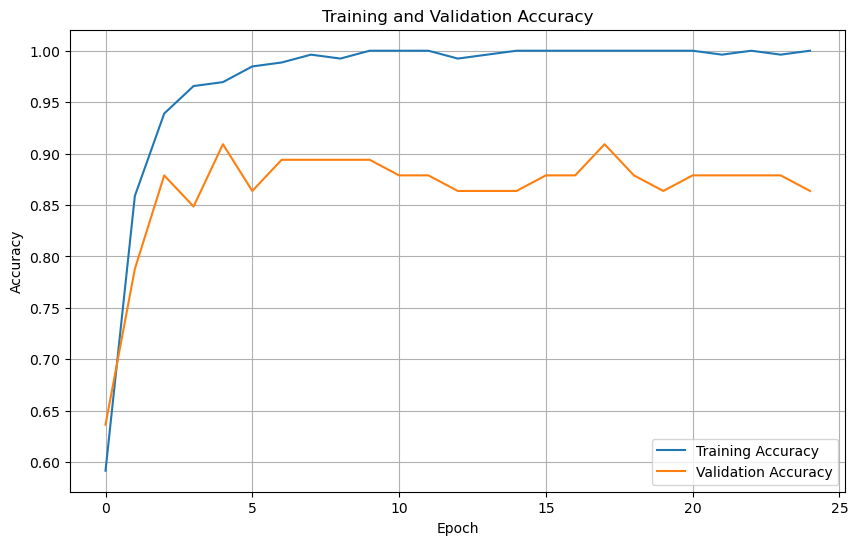

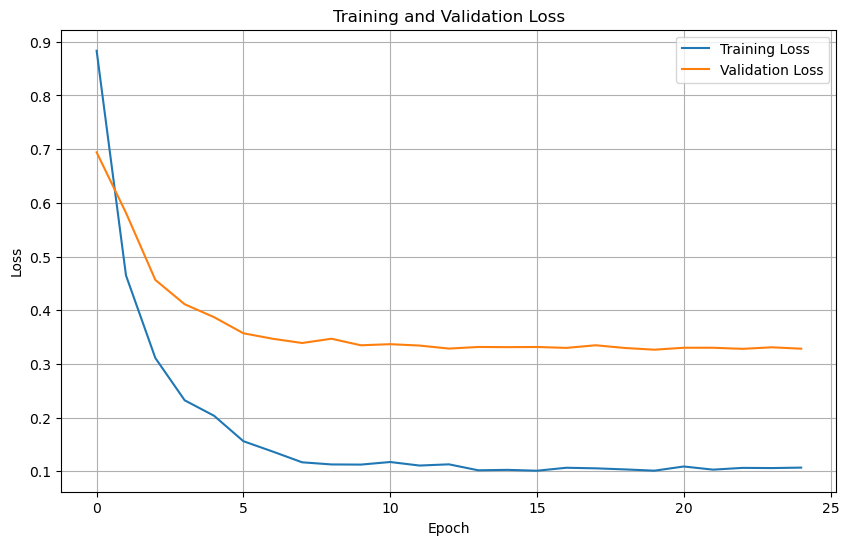

Fold:  3
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 0.9096 Acc: 0.5475
val Loss: 0.8579 Acc: 0.5692

Epoch 1/24
----------
train Loss: 0.4186 Acc: 0.8935
val Loss: 0.6587 Acc: 0.7077

Epoch 2/24
----------
train Loss: 0.3244 Acc: 0.9240
val Loss: 0.6493 Acc: 0.7077

Epoch 3/24
----------
train Loss: 0.2359 Acc: 0.9582
val Loss: 0.5230 Acc: 0.7692

Epoch 4/24
----------
train Loss: 0.1829 Acc: 0.9810
val Loss: 0.4553 Acc: 0.8769

Epoch 5/24
----------
train Loss: 0.1436 Acc: 1.0000
val Loss: 0.4427 Acc: 0.9077

Epoch 6/24
----------
train Loss: 0.1340 Acc: 0.9924
val Loss: 0.4443 Acc: 0.8462

Epoch 7/24
----------
train Loss: 0.1125 Acc: 0.9924
val Loss: 0.4273 Acc: 0.9077

Epoch 8/24
----------
train Loss: 0.1126 Acc: 0.9962
val Loss: 0.4360 Acc: 0.8615

Epoch 9/24
----------
train Loss: 0.1082 Acc: 0.9962
val Loss: 0.4380 Acc: 0.8615

Epoch 10/24
----------
train Loss: 0.1026 Acc: 1.0000
val Loss: 0.4375 Acc: 0.8769

Epoch 11/24
----------
train Loss: 0.1065 Acc:

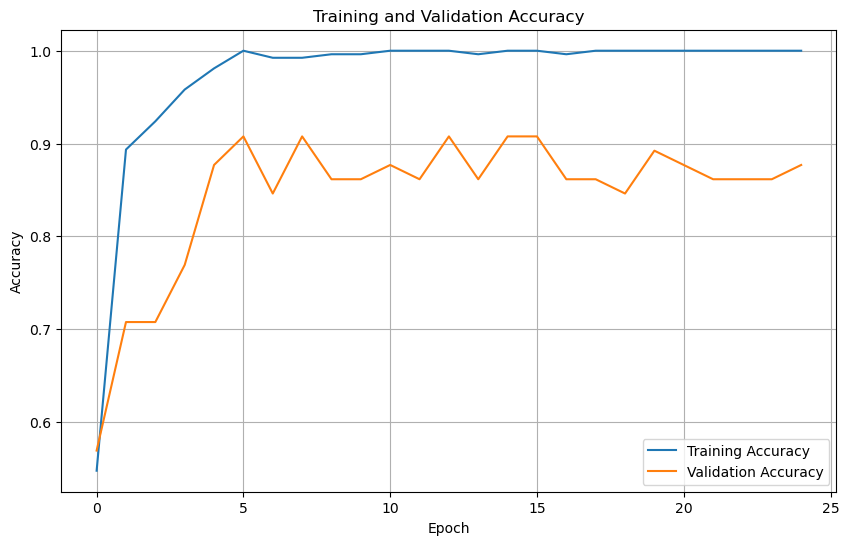

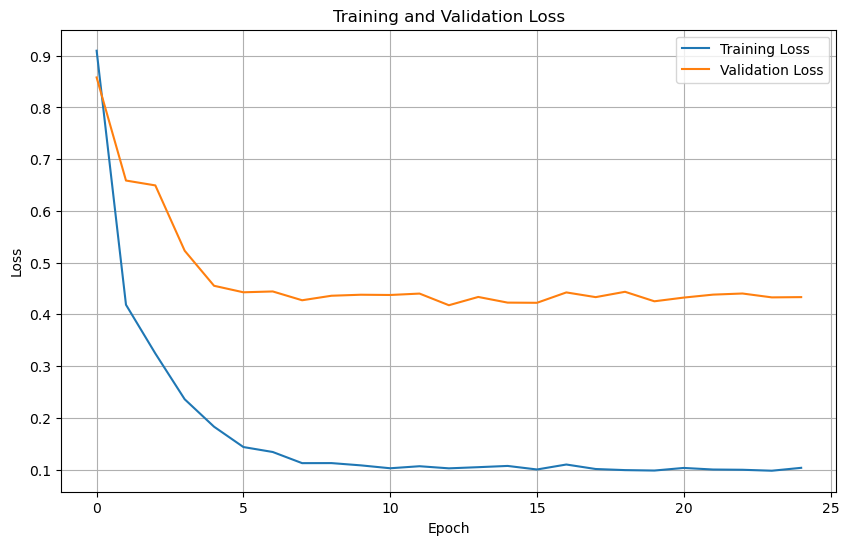

Fold:  4
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 0.8826 Acc: 0.5817
val Loss: 0.6842 Acc: 0.6615

Epoch 1/24
----------
train Loss: 0.4605 Acc: 0.8859
val Loss: 0.4505 Acc: 0.8462

Epoch 2/24
----------
train Loss: 0.3181 Acc: 0.9468
val Loss: 0.3868 Acc: 0.8769

Epoch 3/24
----------
train Loss: 0.2457 Acc: 0.9696
val Loss: 0.3978 Acc: 0.8462

Epoch 4/24
----------
train Loss: 0.1837 Acc: 0.9810
val Loss: 0.3521 Acc: 0.8615

Epoch 5/24
----------
train Loss: 0.1579 Acc: 0.9848
val Loss: 0.3163 Acc: 0.8769

Epoch 6/24
----------
train Loss: 0.1343 Acc: 0.9962
val Loss: 0.3061 Acc: 0.8769

Epoch 7/24
----------
train Loss: 0.1113 Acc: 1.0000
val Loss: 0.2927 Acc: 0.8769

Epoch 8/24
----------
train Loss: 0.1211 Acc: 0.9962
val Loss: 0.3042 Acc: 0.8769

Epoch 9/24
----------
train Loss: 0.1228 Acc: 0.9962
val Loss: 0.2945 Acc: 0.8769

Epoch 10/24
----------
train Loss: 0.1088 Acc: 1.0000
val Loss: 0.2897 Acc: 0.8769

Epoch 11/24
----------
train Loss: 0.1206 Acc:

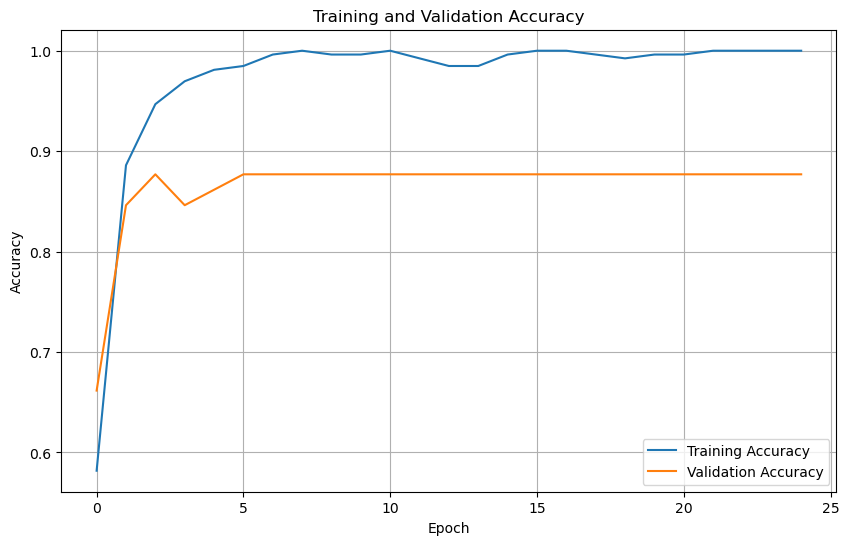

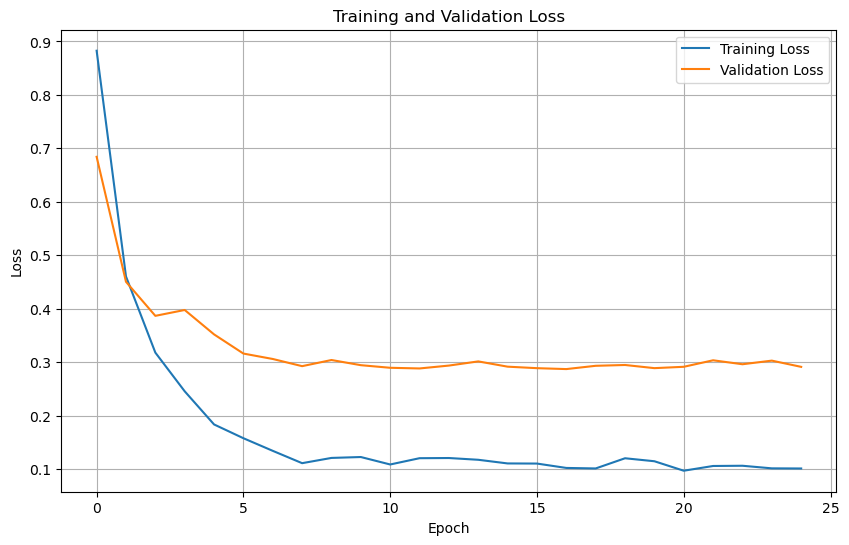

Average accuracy: 0.9360
Average precision: 0.9385
Average recall: 0.9361
Average F1 score: 0.9367
Average Time elapsed: 45.4768 seconds
Memory Usage: 18.0710 MiB


In [12]:
preTrainCPR('voltavision', 'EleComp_dataset', 5, classes)

classes:  ['semi-conductor', 'induction-coil', 'semiconductor-diode', 'stabilizer', 'pulse-generator', 'jumper-cable', 'filament', 'junction-transistor', 'LED', 'clip-lead', 'local-oscillator', 'omni-directional-antenna', 'shunt', 'Integrated-micro-circuit', 'limiter-clipper', 'solenoid', 'step-down-transformer', 'rheostat', 'electric-relay', 'memory-chip', 'PNP-transistor', 'transistor', 'relay', 'step-up-transformer', 'potential-divider', 'attenuator', 'light-circuit', 'Bypass-capacitor', 'heat-sink', 'Electrolytic-capacitor', 'multiplexer', 'cartridge-fuse', 'microchip', 'potentiometer', 'armature', 'microprocessor']
Total images:  421
Training:  336
Testing:  85
Total images:  151
Training:  120
Testing:  31
Total images:  417
Training:  333
Testing:  84
Total images:  162
Training:  129
Testing:  33
Total images:  317
Training:  253
Testing:  64
Total images:  249
Training:  199
Testing:  50
Total images:  400
Training:  320
Testing:  80
Total images:  491
Training:  392
Testing: 

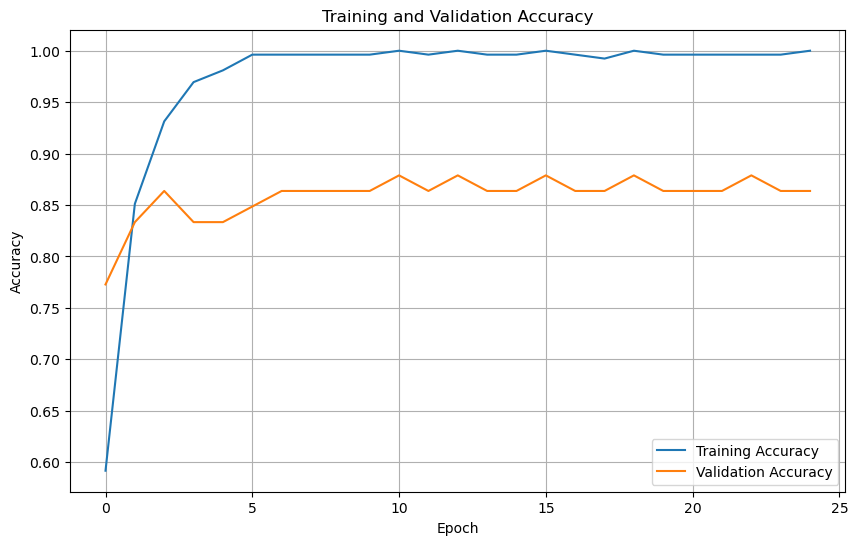

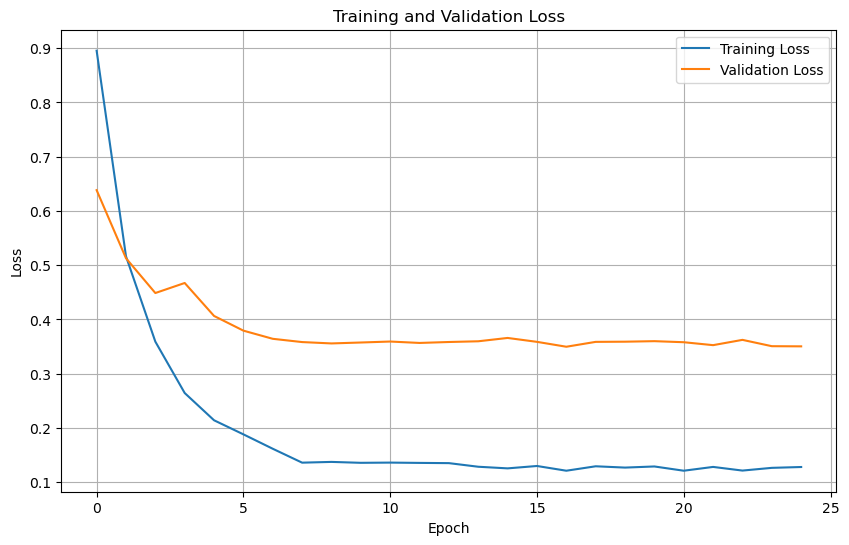

Fold:  1
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 0.9349 Acc: 0.5802
val Loss: 0.7242 Acc: 0.7576

Epoch 1/24
----------
train Loss: 0.5222 Acc: 0.8931
val Loss: 0.5522 Acc: 0.8788

Epoch 2/24
----------
train Loss: 0.3656 Acc: 0.9351
val Loss: 0.4757 Acc: 0.9091

Epoch 3/24
----------
train Loss: 0.2692 Acc: 0.9695
val Loss: 0.4308 Acc: 0.8485

Epoch 4/24
----------
train Loss: 0.2152 Acc: 0.9924
val Loss: 0.4080 Acc: 0.8485

Epoch 5/24
----------
train Loss: 0.1944 Acc: 0.9962
val Loss: 0.3993 Acc: 0.8636

Epoch 6/24
----------
train Loss: 0.1575 Acc: 0.9962
val Loss: 0.3666 Acc: 0.8939

Epoch 7/24
----------
train Loss: 0.1437 Acc: 0.9962
val Loss: 0.3706 Acc: 0.8939

Epoch 8/24
----------
train Loss: 0.1302 Acc: 1.0000
val Loss: 0.3634 Acc: 0.8636

Epoch 9/24
----------
train Loss: 0.1349 Acc: 0.9962
val Loss: 0.3607 Acc: 0.8788

Epoch 10/24
----------
train Loss: 0.1313 Acc: 1.0000
val Loss: 0.3612 Acc: 0.8788

Epoch 11/24
----------
train Loss: 0.1290 Acc:

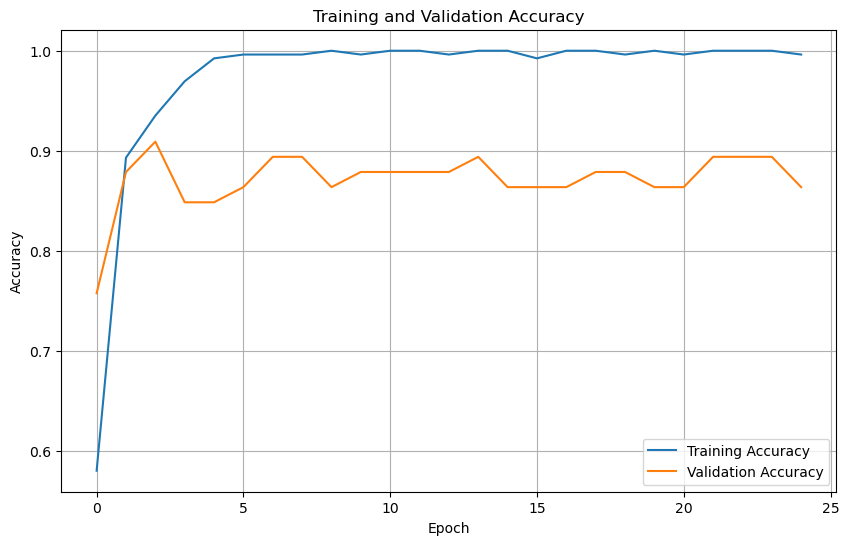

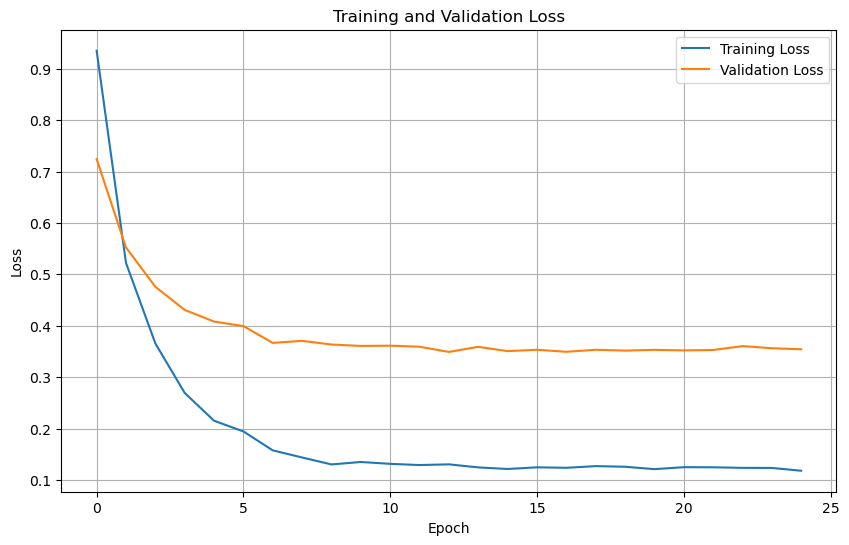

Fold:  2
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 0.9178 Acc: 0.5725
val Loss: 0.7667 Acc: 0.6818

Epoch 1/24
----------
train Loss: 0.5130 Acc: 0.8817
val Loss: 0.6025 Acc: 0.7727

Epoch 2/24
----------
train Loss: 0.3616 Acc: 0.9466
val Loss: 0.5260 Acc: 0.8182

Epoch 3/24
----------
train Loss: 0.2627 Acc: 0.9809
val Loss: 0.4860 Acc: 0.8030

Epoch 4/24
----------
train Loss: 0.2224 Acc: 0.9885
val Loss: 0.4448 Acc: 0.8485

Epoch 5/24
----------
train Loss: 0.1758 Acc: 0.9885
val Loss: 0.4437 Acc: 0.8485

Epoch 6/24
----------
train Loss: 0.1536 Acc: 0.9962
val Loss: 0.4137 Acc: 0.8485

Epoch 7/24
----------
train Loss: 0.1353 Acc: 0.9962
val Loss: 0.4040 Acc: 0.8788

Epoch 8/24
----------
train Loss: 0.1303 Acc: 1.0000
val Loss: 0.4001 Acc: 0.8939

Epoch 9/24
----------
train Loss: 0.1344 Acc: 0.9962
val Loss: 0.4053 Acc: 0.8939

Epoch 10/24
----------
train Loss: 0.1281 Acc: 1.0000
val Loss: 0.4078 Acc: 0.8636

Epoch 11/24
----------
train Loss: 0.1280 Acc:

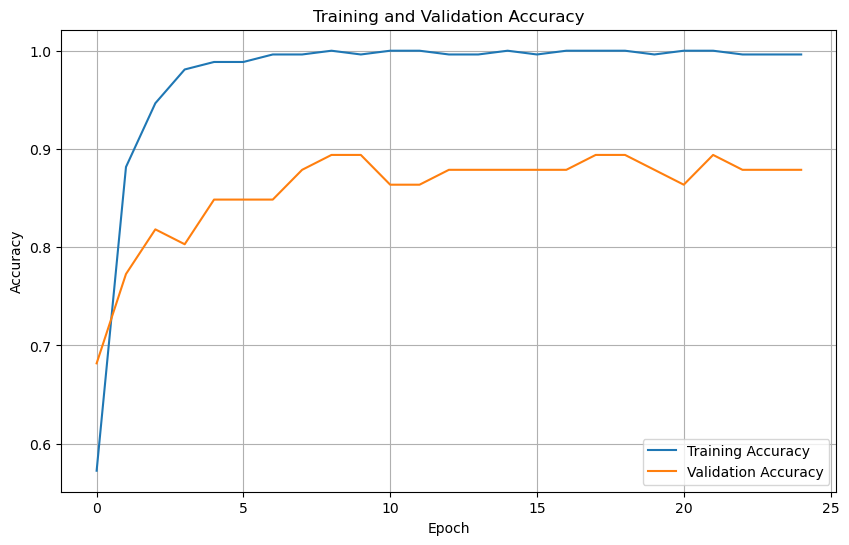

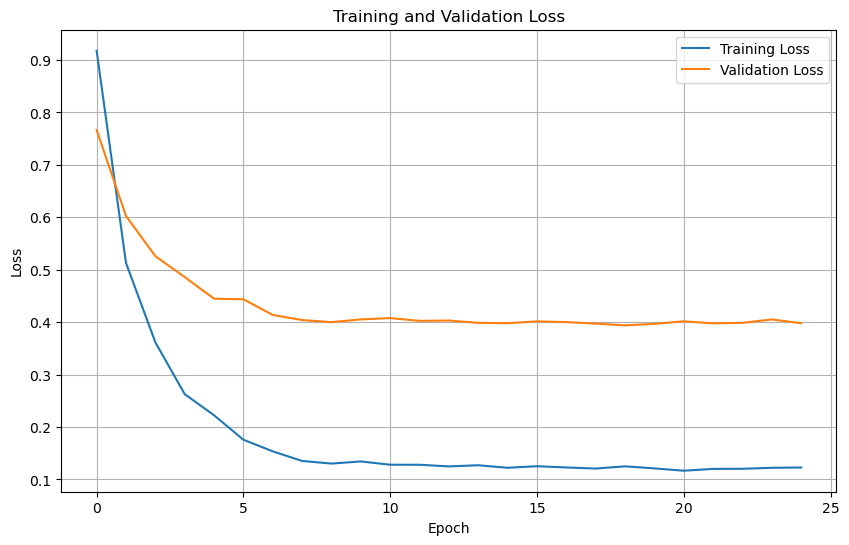

Fold:  3
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 0.9417 Acc: 0.5133
val Loss: 0.7209 Acc: 0.7231

Epoch 1/24
----------
train Loss: 0.5022 Acc: 0.8935
val Loss: 0.5680 Acc: 0.9077

Epoch 2/24
----------
train Loss: 0.3583 Acc: 0.9430
val Loss: 0.5086 Acc: 0.8769

Epoch 3/24
----------
train Loss: 0.2560 Acc: 0.9772
val Loss: 0.4784 Acc: 0.8615

Epoch 4/24
----------
train Loss: 0.2206 Acc: 0.9848
val Loss: 0.4505 Acc: 0.8923

Epoch 5/24
----------
train Loss: 0.1840 Acc: 0.9924
val Loss: 0.4324 Acc: 0.8923

Epoch 6/24
----------
train Loss: 0.1519 Acc: 0.9962
val Loss: 0.4475 Acc: 0.8462

Epoch 7/24
----------
train Loss: 0.1381 Acc: 1.0000
val Loss: 0.4339 Acc: 0.8615

Epoch 8/24
----------
train Loss: 0.1316 Acc: 0.9962
val Loss: 0.4300 Acc: 0.8769

Epoch 9/24
----------
train Loss: 0.1309 Acc: 1.0000
val Loss: 0.4239 Acc: 0.8923

Epoch 10/24
----------
train Loss: 0.1283 Acc: 1.0000
val Loss: 0.4208 Acc: 0.9077

Epoch 11/24
----------
train Loss: 0.1265 Acc:

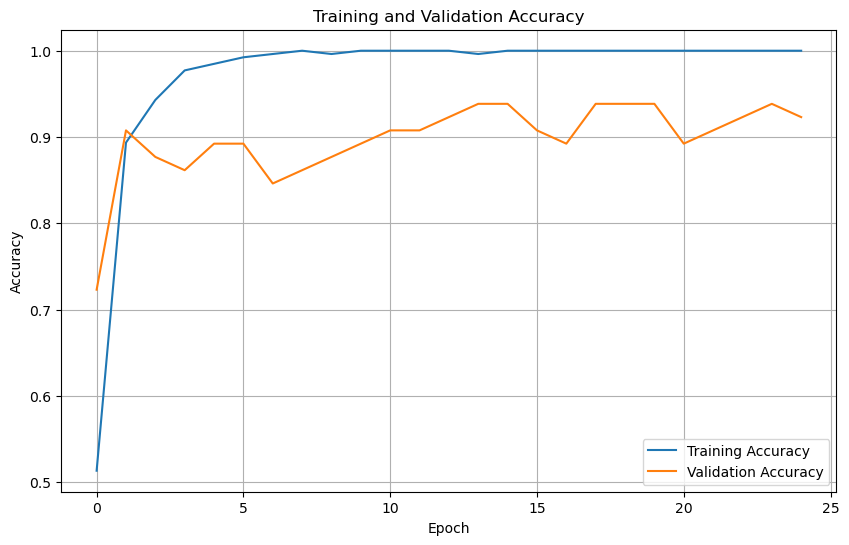

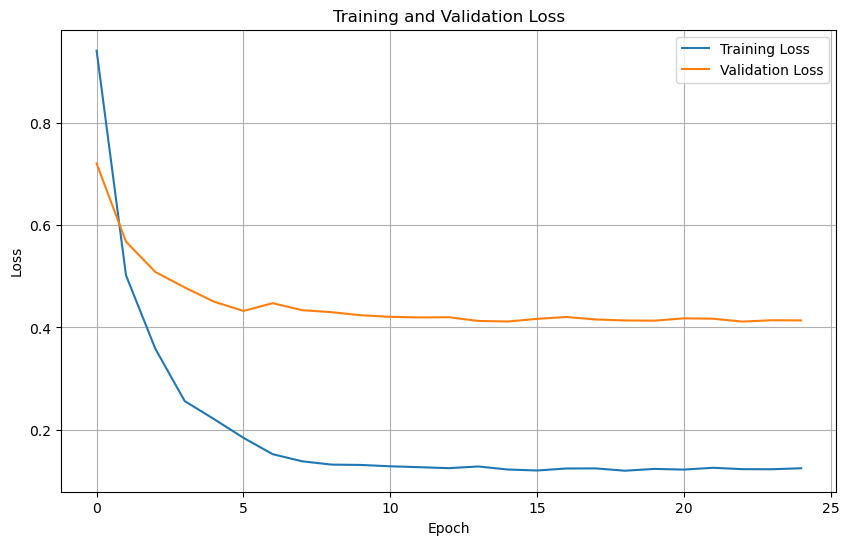

Fold:  4
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 0.9317 Acc: 0.5627
val Loss: 0.7101 Acc: 0.7538

Epoch 1/24
----------
train Loss: 0.5256 Acc: 0.8859
val Loss: 0.5912 Acc: 0.8000

Epoch 2/24
----------
train Loss: 0.3663 Acc: 0.9430
val Loss: 0.5143 Acc: 0.8308

Epoch 3/24
----------
train Loss: 0.2681 Acc: 0.9848
val Loss: 0.4453 Acc: 0.8308

Epoch 4/24
----------
train Loss: 0.2199 Acc: 0.9886
val Loss: 0.4229 Acc: 0.8462

Epoch 5/24
----------
train Loss: 0.1879 Acc: 0.9886
val Loss: 0.4177 Acc: 0.8462

Epoch 6/24
----------
train Loss: 0.1647 Acc: 0.9962
val Loss: 0.3852 Acc: 0.8615

Epoch 7/24
----------
train Loss: 0.1394 Acc: 1.0000
val Loss: 0.3817 Acc: 0.8615

Epoch 8/24
----------
train Loss: 0.1382 Acc: 0.9962
val Loss: 0.3827 Acc: 0.8615

Epoch 9/24
----------
train Loss: 0.1335 Acc: 0.9962
val Loss: 0.3826 Acc: 0.8769

Epoch 10/24
----------
train Loss: 0.1340 Acc: 1.0000
val Loss: 0.3774 Acc: 0.8615

Epoch 11/24
----------
train Loss: 0.1315 Acc:

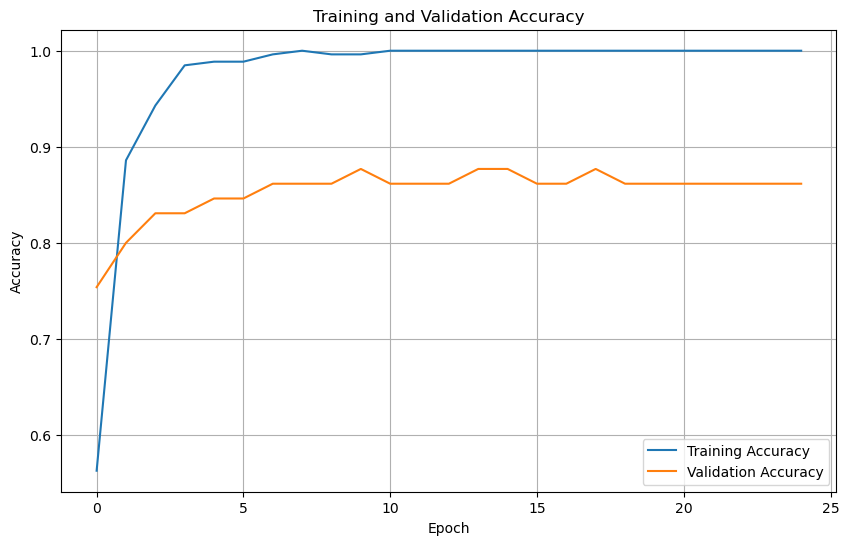

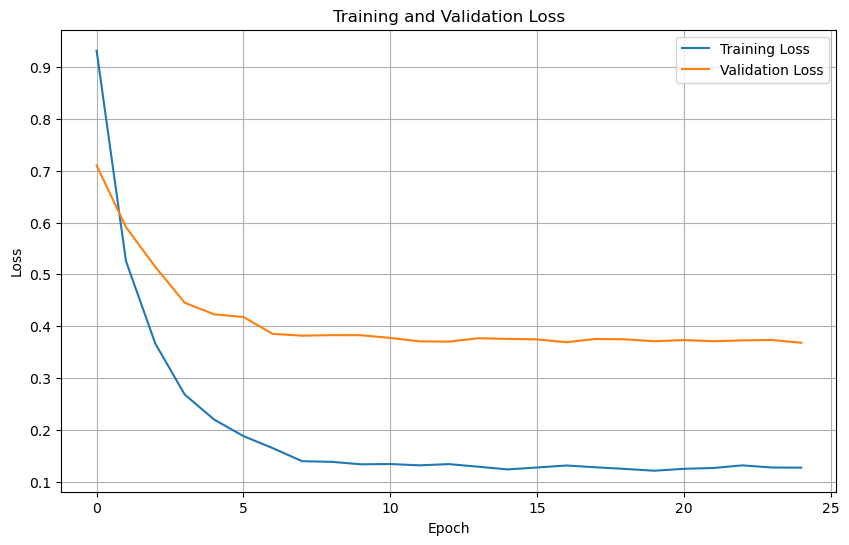

Average accuracy: 0.9180
Average precision: 0.9202
Average recall: 0.9186
Average F1 score: 0.9185
Average Time elapsed: 47.3644 seconds
Memory Usage: 18.9221 MiB


In [13]:
preTrainCPR('voltavision', 'ECD_dataset', 36, classes)

classes:  ['semi-conductor', 'induction-coil', 'semiconductor-diode', 'stabilizer', 'pulse-generator', 'jumper-cable', 'filament', 'junction-transistor', 'LED', 'clip-lead', 'local-oscillator', 'omni-directional-antenna', 'shunt', 'Integrated-micro-circuit', 'limiter-clipper', 'solenoid', 'step-down-transformer', 'rheostat', 'electric-relay', 'memory-chip', 'PNP-transistor', 'transistor', 'relay', 'step-up-transformer', 'potential-divider', 'attenuator', 'light-circuit', 'Bypass-capacitor', 'heat-sink', 'Electrolytic-capacitor', 'multiplexer', 'cartridge-fuse', 'microchip', 'potentiometer', 'armature', 'microprocessor']
Total images:  421
Training:  336
Testing:  85
Total images:  151
Training:  120
Testing:  31
Total images:  417
Training:  333
Testing:  84
Total images:  162
Training:  129
Testing:  33
Total images:  317
Training:  253
Testing:  64
Total images:  249
Training:  199
Testing:  50
Total images:  400
Training:  320
Testing:  80
Total images:  491
Training:  392
Testing: 

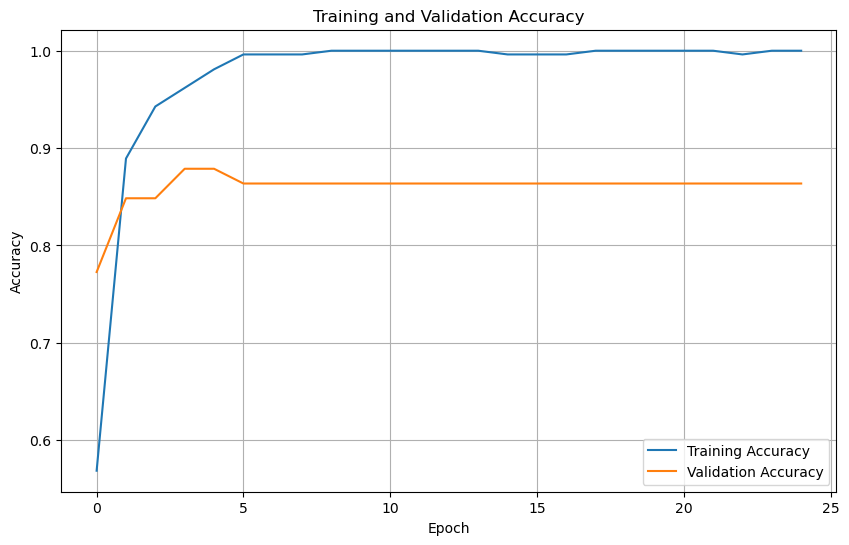

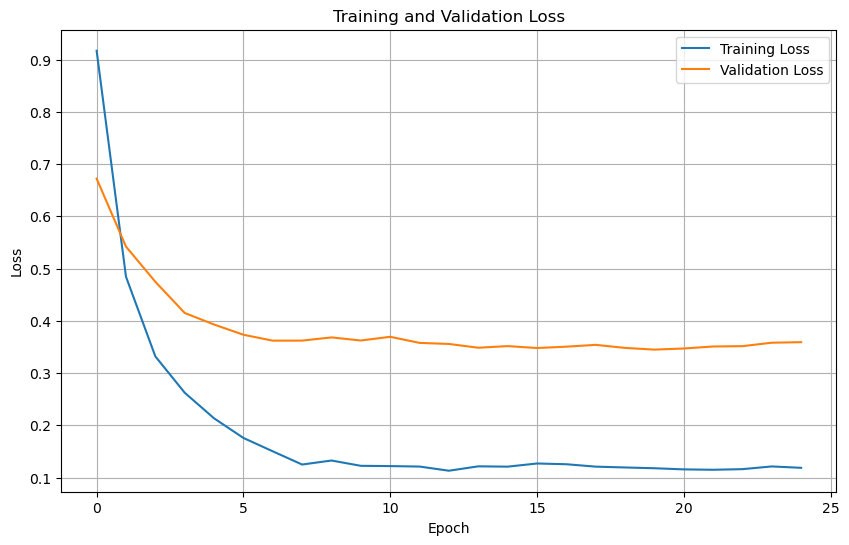

Fold:  1
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 0.9019 Acc: 0.5840
val Loss: 0.6421 Acc: 0.7576

Epoch 1/24
----------
train Loss: 0.4921 Acc: 0.8893
val Loss: 0.5427 Acc: 0.8333

Epoch 2/24
----------
train Loss: 0.3361 Acc: 0.9427
val Loss: 0.4593 Acc: 0.8030

Epoch 3/24
----------
train Loss: 0.2577 Acc: 0.9656
val Loss: 0.3945 Acc: 0.8485

Epoch 4/24
----------
train Loss: 0.1973 Acc: 0.9885
val Loss: 0.3746 Acc: 0.8788

Epoch 5/24
----------
train Loss: 0.1741 Acc: 1.0000
val Loss: 0.3595 Acc: 0.8636

Epoch 6/24
----------
train Loss: 0.1527 Acc: 0.9924
val Loss: 0.3422 Acc: 0.8636

Epoch 7/24
----------
train Loss: 0.1239 Acc: 1.0000
val Loss: 0.3436 Acc: 0.8939

Epoch 8/24
----------
train Loss: 0.1159 Acc: 1.0000
val Loss: 0.3385 Acc: 0.8333

Epoch 9/24
----------
train Loss: 0.1171 Acc: 1.0000
val Loss: 0.3380 Acc: 0.8636

Epoch 10/24
----------
train Loss: 0.1199 Acc: 1.0000
val Loss: 0.3375 Acc: 0.8636

Epoch 11/24
----------
train Loss: 0.1170 Acc:

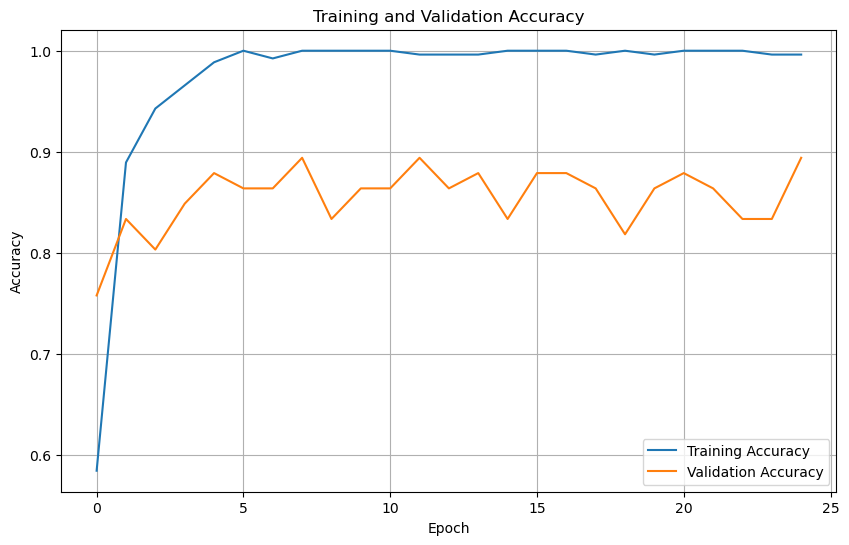

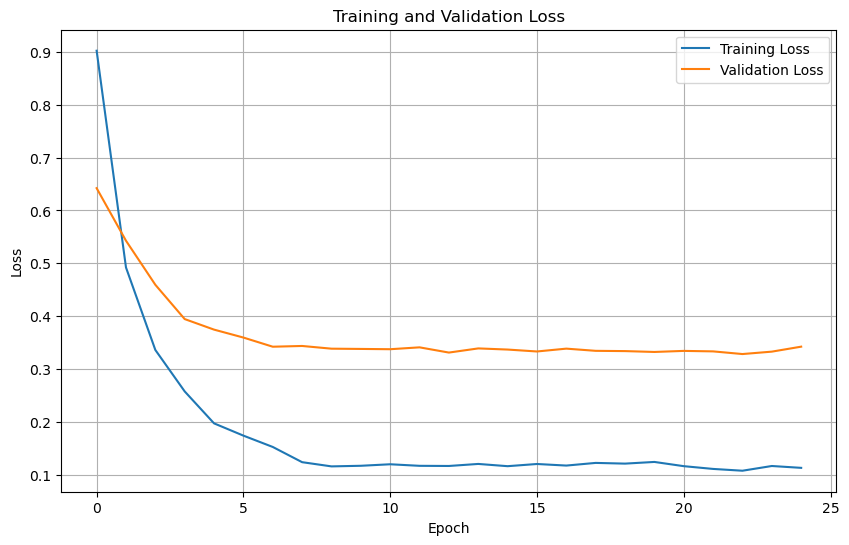

Fold:  2
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 0.9248 Acc: 0.5573
val Loss: 0.7497 Acc: 0.6818

Epoch 1/24
----------
train Loss: 0.4817 Acc: 0.8855
val Loss: 0.5864 Acc: 0.7727

Epoch 2/24
----------
train Loss: 0.3143 Acc: 0.9618
val Loss: 0.4951 Acc: 0.8485

Epoch 3/24
----------
train Loss: 0.2422 Acc: 0.9847
val Loss: 0.4655 Acc: 0.8636

Epoch 4/24
----------
train Loss: 0.1879 Acc: 0.9962
val Loss: 0.4494 Acc: 0.8636

Epoch 5/24
----------
train Loss: 0.1751 Acc: 0.9962
val Loss: 0.4326 Acc: 0.8636

Epoch 6/24
----------
train Loss: 0.1392 Acc: 0.9962
val Loss: 0.4239 Acc: 0.8333

Epoch 7/24
----------
train Loss: 0.1231 Acc: 1.0000
val Loss: 0.4185 Acc: 0.8636

Epoch 8/24
----------
train Loss: 0.1120 Acc: 1.0000
val Loss: 0.4233 Acc: 0.8636

Epoch 9/24
----------
train Loss: 0.1142 Acc: 1.0000
val Loss: 0.4194 Acc: 0.8636

Epoch 10/24
----------
train Loss: 0.1173 Acc: 1.0000
val Loss: 0.4194 Acc: 0.8636

Epoch 11/24
----------
train Loss: 0.1135 Acc:

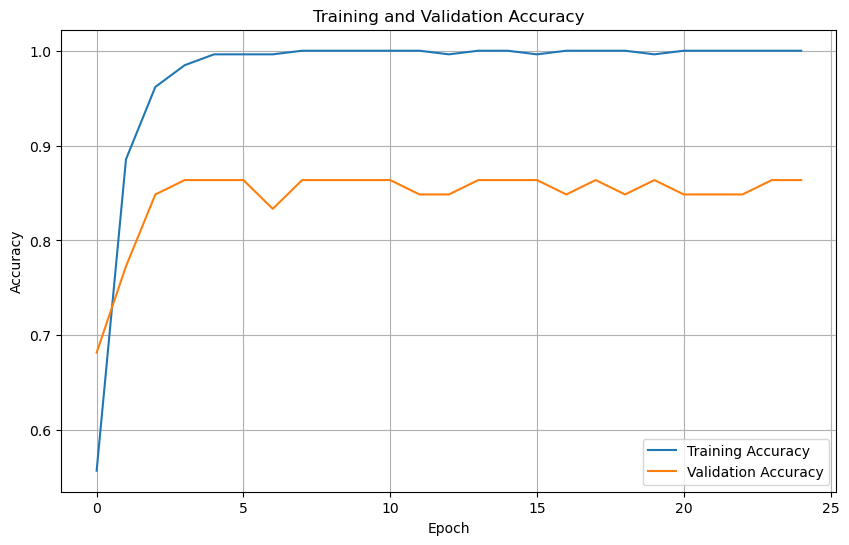

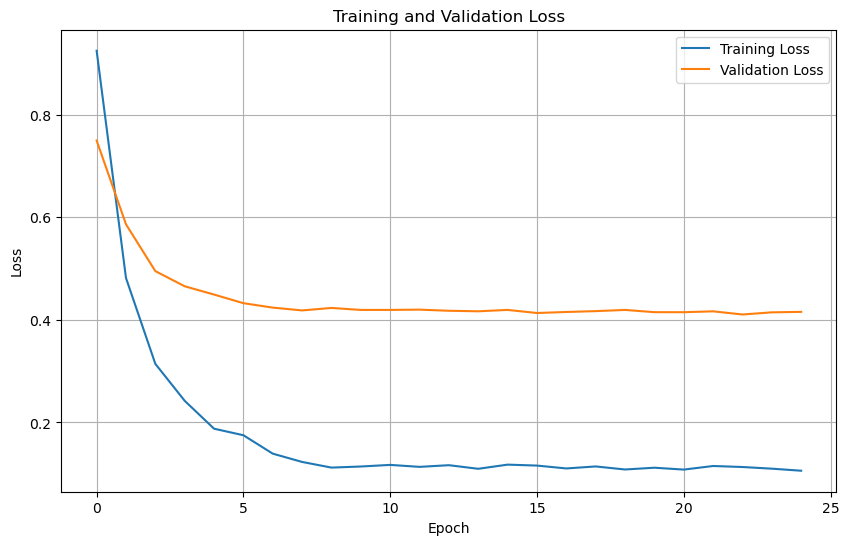

Fold:  3
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 0.9092 Acc: 0.5627
val Loss: 0.7443 Acc: 0.7385

Epoch 1/24
----------
train Loss: 0.4832 Acc: 0.8783
val Loss: 0.6386 Acc: 0.7538

Epoch 2/24
----------
train Loss: 0.3413 Acc: 0.9430
val Loss: 0.5399 Acc: 0.7846

Epoch 3/24
----------
train Loss: 0.2600 Acc: 0.9810
val Loss: 0.5052 Acc: 0.8615

Epoch 4/24
----------
train Loss: 0.2020 Acc: 0.9886
val Loss: 0.4826 Acc: 0.8154

Epoch 5/24
----------
train Loss: 0.1609 Acc: 0.9962
val Loss: 0.4672 Acc: 0.8462

Epoch 6/24
----------
train Loss: 0.1516 Acc: 0.9924
val Loss: 0.4534 Acc: 0.8615

Epoch 7/24
----------
train Loss: 0.1175 Acc: 0.9962
val Loss: 0.4514 Acc: 0.8615

Epoch 8/24
----------
train Loss: 0.1179 Acc: 0.9962
val Loss: 0.4408 Acc: 0.8769

Epoch 9/24
----------
train Loss: 0.1226 Acc: 1.0000
val Loss: 0.4456 Acc: 0.8769

Epoch 10/24
----------
train Loss: 0.1154 Acc: 1.0000
val Loss: 0.4436 Acc: 0.8769

Epoch 11/24
----------
train Loss: 0.1216 Acc:

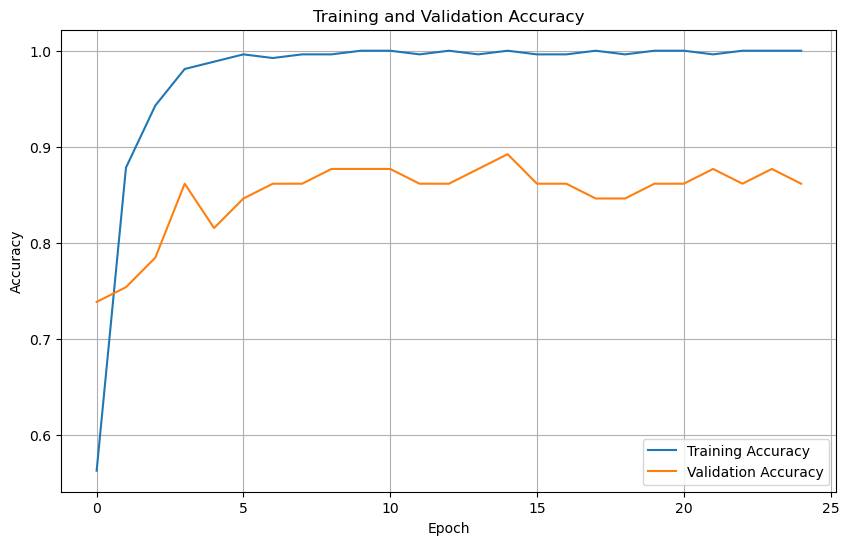

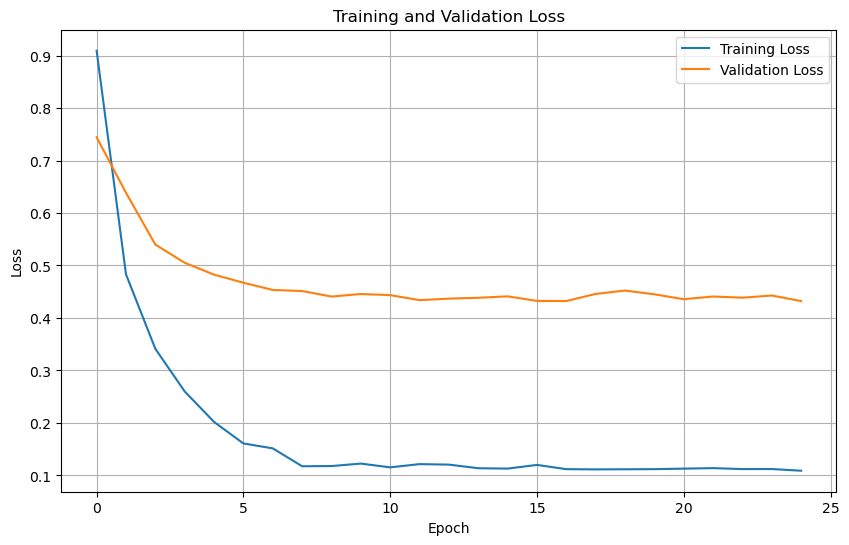

Fold:  4
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 0.9312 Acc: 0.5171
val Loss: 0.6909 Acc: 0.7385

Epoch 1/24
----------
train Loss: 0.5076 Acc: 0.8707
val Loss: 0.5384 Acc: 0.8462

Epoch 2/24
----------
train Loss: 0.3379 Acc: 0.9620
val Loss: 0.5033 Acc: 0.8154

Epoch 3/24
----------
train Loss: 0.2591 Acc: 0.9620
val Loss: 0.4438 Acc: 0.8769

Epoch 4/24
----------
train Loss: 0.2049 Acc: 0.9924
val Loss: 0.4220 Acc: 0.8769

Epoch 5/24
----------
train Loss: 0.1780 Acc: 0.9848
val Loss: 0.4007 Acc: 0.8769

Epoch 6/24
----------
train Loss: 0.1460 Acc: 0.9924
val Loss: 0.4090 Acc: 0.8462

Epoch 7/24
----------
train Loss: 0.1275 Acc: 1.0000
val Loss: 0.4028 Acc: 0.8615

Epoch 8/24
----------
train Loss: 0.1320 Acc: 0.9962
val Loss: 0.3974 Acc: 0.8462

Epoch 9/24
----------
train Loss: 0.1233 Acc: 1.0000
val Loss: 0.3844 Acc: 0.8615

Epoch 10/24
----------
train Loss: 0.1216 Acc: 1.0000
val Loss: 0.3885 Acc: 0.8615

Epoch 11/24
----------
train Loss: 0.1191 Acc:

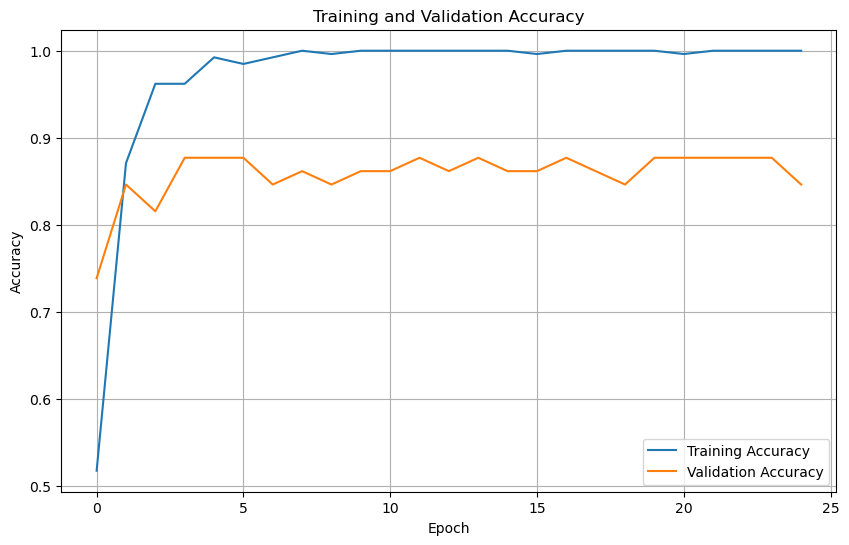

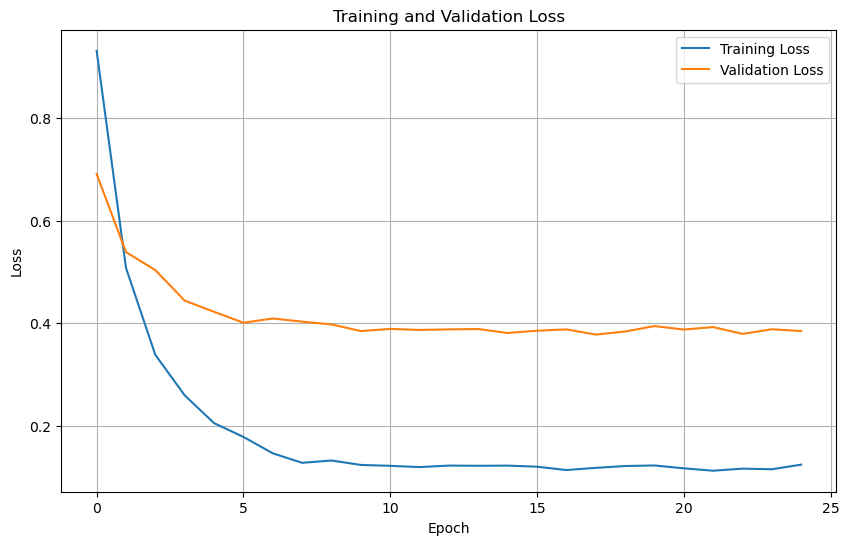

Average accuracy: 0.9260
Average precision: 0.9231
Average recall: 0.9264
Average F1 score: 0.9238
Average Time elapsed: 46.8091 seconds
Memory Usage: 18.9221 MiB


In [14]:
preTrainCPR('voltavision', 'ECD_dataset', 36, classes)